# Pre-processing and modeling

#### In this model, the additional dataset has been used to create new features and the model is trained using these features.

## 1. Loading Data and Packages  

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\praty\anaconda3\lib\site-packages (19.2.3)


In [2]:
from category_encoders import OrdinalEncoder, OneHotEncoder
import eli5
from eli5.sklearn import PermutationImportance

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from tqdm import tqdm_notebook as tqdm
from lightgbm import LGBMRegressor
import lightgbm as lgb


Using TensorFlow backend.


In [4]:
trainval = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\train.csv')
test = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train/\test.csv')
structures = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\structures.csv')
dipole = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\dipole_moments.csv')
contrib = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\scalar_coupling_contributions.csv')
magnetic = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\magnetic_shielding_tensors.csv')
mulliken = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\mulliken_charges.csv')
potential_energy = pd.read_csv(r'C:\Users\praty\Documents\backup work data science\work\capstone\datasets\train\potential_energy.csv')


In [ ]:
#pickling the data
try:
    with open('pkl/merged.pkl', 'wb') asf

## 1b. Summary of EDA
a. Looking at the data, we can see that the train and test sets had relatively even distributions of scalar coupling type and of the number of atoms present in each dataset. This tells us that the train data is a good enough representation of the test data in order to create a model that predicts the scalar coupling constants. b. The distribution of the scalar coupling constant values isolated by type also reveals that there are clear differences in the ranges that these values appear in. This gives us the insight that different molecular properties affect each type of J coupling differently and unique models should be used for all 8 coupling types found in the dataset. c. The test set structure is the same as the training except that we don't have the scalar_coupling_constant column. Among the other datasets, the most promising seems to be structures.csv, as it is the only one that is available for both training and testing sets. All the other dataframes are available only for the former. d. It is mentioned in the problem statement that the molecules listed for train and test are totally different. e. there are no null values for both train and test

# 2. Reduce Memory Function
This function reduces the numeric to the least possible numeric type that fits the data so 
memory usage during transforming and training will be reduced.

Source: https://www.kaggle.com/todnewman/keras-neural-net-for-champs

In [7]:
def reduce_mem_usage(df, verbose=True):
    """
    
    Han
    Parameters:
    ===========
    dataframe: input dataframe 
    verbose: verbose mode, default True.
    Output:
    ===========
    dataframe: dataframe with numeric columns types changed to the least possible size
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 3. Create features on structures

In [8]:
!pip install tqdm
from tqdm import tqdm_notebook as tqdm
# get a reliable estimate of how long it will take.
# see immediately if it’s stuck.

## 3a. Bond counts by element
Based on the number of electrons in an atom's valence shell, we know how many bonds the atom needs to be stable. Hydrogen needs 1, Flourine needs 1, Oxygen needs 2, Nitrogen needs 3, and Carbon needs 4. Bonds can be single, double, or triple, but we have not yet calculated the strength of the bonds. Therefore there is a range of valid bond counts we could get for each atom.


## 3b. Using the atomic radii, electronegativity values of the atoms (C, H, N, O, F), 
new features like atoms_rad and atoms_en are created. The number of bonds as n_bonds and bond_lengths_mean. This gives a new structutres file. Here we create a dictionary of a new column with the new values then pass the values to the dataframe


## 3c. Fudge factor is to account for unceratainty
the fudge values are added slightly, in order to reduce false negatives. Atoms that are not bonded repel each other, so it should be rare that this increase will result in false positives.


In [9]:
%time
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

i_atom = structures['atom_index'].values # a list of all 'atom_index' in structures
p = structures[['x', 'y', 'z']].values  # a list of cartesian coordinates (x,y,z) values in structures
p_compare = p
m = structures['molecule_name'].values # a list of molecule name in structures
m_compare = m
r = structures['rad'].values # a list of rad in structures
r_compare = r

source_row = np.arange(len(structures)) # returns an array of evenly spaced values
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule? We are trying to compare to 
                                          # to distinguish between two different molecules.
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))


Wall time: 0 ns
{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}



Calculating bonds



Counting and condensing bonds


,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,1,1.091953
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.80,3,1.017195
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.43,1,1.017190
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.43,1,1.017187
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.43,1,1.017208
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.78,2,0.962107


# 4. Function to merge structures data with train data 

In [10]:
def merge_train_structures(train, structures):
  
  """This function is used to merge the structures dataset to the 
     original train dataset
     
     Parameters:
     ===========
train: train dataframe
structures: structures dataframe.
     
     Output:
     ===========
     dataframe: merged dataframe
     """
  
  structures = structures.rename({'atom_index': 'atom_index_0',
                                  'x':'x_0', 'y':'y_0', 'z':'z_0',
                                  'atom':'atom_0'}, axis=1)
  
  merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])
  
  structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)
  
  merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])
  
  structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
  
  assert train.shape[0] == merged.shape[0]
  
  return merged_1

In [11]:
merged = merge_train_structures(trainval, structures)

In [12]:
merged.head(1)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,...,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.09195


In [13]:
merged.shape

(4658147, 22)

In [14]:
assert len(merged) == len(trainval)
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,...,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,...,1,1.091952,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,...,1,1.091946,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,...,1,1.091948,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,...,1,1.091953,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952


# 5. Function to merge Mulliken charges with previously merged dataset
Here the number of features have been increased to 24 from 22

In [15]:
mulliken = mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_1'])
assert len(merged) == len(trainval)

In [16]:
merged.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,mulliken_charge_0,mulliken_charge_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,...,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.09195,0.133921,-0.535689


In [17]:
merged.shape

(4658147, 24)

# 6. Creating features
1. distance — the distance between the given cartesian points of each atom
2. n_bonds — the number of bonds on a specific atom
3. mu — the square root of the sum of the squared Cartesian values
4. delta_en — the difference between the electronegativities of two atoms
5. Advanced features were created with the help of a few helpful Kaggle kernels

In [18]:
%%time
# This block is creating distance 'dist' feature using the linalg and merging with the 'merged' file.

train_p_0 = merged[['x_0', 'y_0', 'z_0']].values
train_p_1 = merged[['x_1', 'y_1', 'z_1']].values

merged['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)

assert len(merged) == len(trainval)#assert len means confirming no of items in merged and trainval

Wall time: 2.46 s


In [19]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,mulliken_charge_0,mulliken_charge_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,...,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133921,-0.535689,1.091953
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,...,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133922,-0.535689,1.091952
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,...,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133923,-0.535689,1.091946
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,...,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133923,-0.535689,1.091948
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,...,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.133921,0.133922,1.783120


## 6a. Creating aggregate functions like count, mean and min 

In [20]:
merged['type'].value_counts()
merged['molecule_couples'] = merged.groupby('molecule_name')['id'].transform('count')

In [21]:
 merged['molecule_dist_mean'] = merged.groupby('molecule_name')['dist'].transform('mean')

In [22]:
 merged['molecule_dist_min'] = merged.groupby('molecule_name')['dist'].transform('min')

In [23]:
external_data_0 = pd.DataFrame(data={
    'atom_0': ['C', 'H', 'N', 'O', 'F'],
    'atom_0_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_0': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_0': [4, 1, 5, 6, 7]
})
external_data_1 = pd.DataFrame(data={
    'atom_1': ['C', 'H', 'N', 'O', 'F'],
    'atom_1_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_1': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_1': [4, 1, 5, 6, 7]
})
   

In [24]:
#%%time
def create_features(df):
    df['bond'] = df['type'].str[2:]
    df['j_type'] = df['type'].str[:2]
    df['distance'] = ((df['x_1'].values - df['x_0'].values)**2 + 
                    (df['y_1'].values - df['y_0'].values)**2 + 
                    (df['z_1'].values - df['z_0'].values)**2)** 0.5
    df['mu_0'] = np.sqrt(df['x_0'].values**2 + df['y_0'].values**2 + df['z_0'].values**2)
    df['mu_1'] = np.sqrt(df['x_1'].values**2 + df['y_1'].values**2 + df['z_1'].values**2)
    df = df.merge(external_data_0, on='atom_0', how='left')
    df = df.merge(external_data_1, on='atom_1', how='left')
    df['delta_en'] = (df['atom_0_en'] - df['atom_1_en']).abs()
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df['molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df['molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df['molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df['molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df['molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df['molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df['molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df['molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df['molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df['molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df['molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df['molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df['molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df['molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df['molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df['molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df['molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df['molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df['molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df['molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df['molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df['molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df['molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df['molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df['molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df['molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df['molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df['molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df['molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df['molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df['molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df['molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df['molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df['molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df 


In [25]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df_train):
    
    
    df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
#     df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df_train = map_atom_info(df_train,df_temp, atom_idx)
        df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
       
                                            
                                            
                                            'distance_closest': f'distance_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})
    df_train = reduce_mem_usage(df_train)
    return df_train


In [26]:
#%%time Merging the 'merged' to the 'create_features' and asserting the length

merged = create_features(merged)
assert len(merged) == len(trainval)


Mem. usage decreased to 915.13 Mb (68.6% reduction)


In [27]:
#%%time
dtrain = create_closest(merged)

Mem. usage decreased to 999.53 Mb (2.6% reduction)


In [28]:
dtrain['dist'].isnull().sum(), dtrain['dist'].shape

(3689501, (4658147,))

In [29]:
dtrain['dist'].isnull().sum()

3689501

In [30]:
assert len(dtrain) == len(trainval)

In [31]:
dtrain.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,...,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,...,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,...,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN
3,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,...,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,0,1.091797,-0.012695,1.085938,0.008003,0.0,1.091797,-0.012695,1.085938,0.008003


## 6b. Create cosine, dihedral angle features 

In [1]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    df = reduce_mem_usage(df)
    return df
    
merged = add_cos_features(dtrain)


NameError: name 'dtrain' is not defined

In [33]:
assert len(merged) == len(trainval)
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
3,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,0.0,1.091797,-0.012695,1.085938,0.008003,1.091797,1.091797,-0.333496,-1.333008,1.333984


In [34]:
# Now we have a shape with 96 features but many 'dist' features have null values so we will delete them later 
#before modelling while selecting the features.

merged.shape


(4658147, 96)

In [38]:
import pickle
# pickle.dump(merged,open('pkl/merged.pkl', 'wb'))

create a folder in the same dir say as pkl and store the files 

In [40]:
try:
    with open('pkl/merged.pkl', 'wb') as f:
        pickle.dump(merged, f)
except Exception as ex:
    print(ex)

## 7. Scoring Function 
we are using log of MAE as scoring function as it is robust against the outliers

In [41]:
groups = merged['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true - y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

# 8. Splitting the dataset according to coupling type
So we have 8 coupling types and thus 8 such models

In [42]:
trainval_1JHC = merged[merged['type'] == '1JHC']
trainval_1JHN = merged[merged['type'] == '1JHN']
trainval_2JHH = merged[merged['type'] == '2JHH']
trainval_2JHN = merged[merged['type'] == '2JHN']
trainval_2JHC = merged[merged['type'] == '2JHC']
trainval_3JHH = merged[merged['type'] == '3JHH']
trainval_3JHC = merged[merged['type'] == '3JHC']
trainval_3JHN = merged[merged['type'] == '3JHN']

# 9. train_test_split of complete dataset 

This splitting is again based on molecules
Grouping the data according to the molecule names

The training data includes more than 1 observation under each molecule_name. Because of this nature, we had to be considerate to not leak data from train molecules into the validation set. We did a train_test_split() on the molecule_name instead, and created train/val subsets with the data from each J type — now 16 subsets total!
Creating features like count, mean, min using distance

In [43]:
# all the molecules under the same coupling type 

train_1JHC, test_1JHC = train_test_split(trainval_1JHC, shuffle=False, random_state=47)

train_1JHC_molecules = train_1JHC['molecule_name'].unique()
test_1JHC_molecules = np.delete(test_1JHC['molecule_name'].unique(), 0)

train_1JHC = train_1JHC[train_1JHC['molecule_name'].isin(train_1JHC_molecules)]
test_1JHC = test_1JHC[test_1JHC['molecule_name'].isin(test_1JHC_molecules)]

In [44]:
train_1JHN, test_1JHN = train_test_split(trainval_1JHN, shuffle=False, random_state=47)

train_1JHN_molecules = train_1JHN['molecule_name'].unique()
test_1JHN_molecules = np.delete(test_1JHN['molecule_name'].unique(), 0)

train_1JHN = train_1JHN[train_1JHN['molecule_name'].isin(train_1JHN_molecules)]
test_1JHN = test_1JHN[test_1JHN['molecule_name'].isin(test_1JHN_molecules)]

In [45]:
train_2JHH, test_2JHH = train_test_split(trainval_2JHH, shuffle=False, random_state=47)

train_2JHH_molecules = train_2JHH['molecule_name'].unique()
test_2JHH_molecules = np.delete(test_2JHH['molecule_name'].unique(), 0)

train_2JHH = train_2JHH[train_2JHH['molecule_name'].isin(train_2JHH_molecules)]
test_2JHH = test_2JHH[test_2JHH['molecule_name'].isin(test_2JHH_molecules)]

In [46]:
train_2JHH.shape

(283527, 96)

In [47]:
test_2JHH.shape

(94507, 96)

In [48]:
test_2JHH_molecules.shape

(17861,)

In [49]:
train_2JHN, test_2JHN = train_test_split(trainval_2JHN, shuffle=False, random_state=47)

train_2JHN_molecules = train_2JHN['molecule_name'].unique()
test_2JHN_molecules = np.delete(test_2JHN['molecule_name'].unique(), 0)

train_2JHN = train_2JHN[train_2JHN['molecule_name'].isin(train_2JHN_molecules)]
test_2JHN = test_2JHN[test_2JHN['molecule_name'].isin(test_2JHN_molecules)]

In [50]:
test_2JHN_molecules.shape

(10305,)

In [51]:
type(test_2JHN_molecules)

numpy.ndarray

In [52]:
test_2JHN.shape

(29813, 96)

In [53]:
train_2JHC, test_2JHC = train_test_split(trainval_2JHC, shuffle=False, random_state=47)

train_2JHC_molecules = train_2JHC['molecule_name'].unique()
test_2JHC_molecules = np.delete(test_2JHC['molecule_name'].unique(), 0)

train_2JHC = train_2JHC[train_2JHC['molecule_name'].isin(train_2JHC_molecules)]
test_2JHC = test_2JHC[test_2JHC['molecule_name'].isin(test_2JHC_molecules)]

In [54]:
train_3JHH, test_3JHH = train_test_split(trainval_3JHH, shuffle=False, random_state=47)

train_3JHH_molecules = train_3JHH['molecule_name'].unique()
test_3JHH_molecules = np.delete(test_3JHH['molecule_name'].unique(), 0)

train_3JHH = train_3JHH[train_3JHH['molecule_name'].isin(train_3JHH_molecules)]
test_3JHH = test_3JHH[test_3JHH['molecule_name'].isin(test_3JHH_molecules)]

In [55]:
train_3JHC, test_3JHC = train_test_split(trainval_3JHC, shuffle=False, random_state=47)

train_3JHC_molecules = train_3JHC['molecule_name'].unique()
test_3JHC_molecules = np.delete(test_3JHC['molecule_name'].unique(), 0)

train_3JHC = train_3JHC[train_3JHC['molecule_name'].isin(train_3JHC_molecules)]
test_3JHC = test_3JHC[test_3JHC['molecule_name'].isin(test_3JHC_molecules)]

In [56]:
train_3JHN, test_3JHN = train_test_split(trainval_3JHN, shuffle=False, random_state=47)

train_3JHN_molecules = train_3JHN['molecule_name'].unique()
test_3JHN_molecules = np.delete(test_3JHN['molecule_name'].unique(), 0)

train_3JHN = train_3JHN[train_3JHN['molecule_name'].isin(train_3JHN_molecules)]
test_3JHN = test_3JHN[test_3JHN['molecule_name'].isin(test_3JHN_molecules)]

In [57]:
train_1JHC_molecules

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000005', 'dsgdb9nsd_000007', ...,
       'dsgdb9nsd_101744', 'dsgdb9nsd_101745', 'dsgdb9nsd_101746'],
      dtype=object)

In [58]:
train_1JHC.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8125,H,0.002150,-0.006031,0.001976,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8125,H,1.011719,1.463867,0.000277,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8125,H,-0.541016,1.447266,-0.876465,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8125,H,-0.523926,1.437500,0.906250,...,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
17,17,dsgdb9nsd_000005,2,0,1JHC,171.2500,H,-0.027802,2.199219,0.014153,...,NaN,NaN,NaN,NaN,NaN,1.066406,NaN,NaN,NaN,NaN


# 10. Defining features and target
We can see above that there are several features with NaN values and we eliminate them before modeling

In [59]:
new_features_1 = ['EN_x', 'rad_x', 'n_bonds_x', 'bond_lengths_mean_x', 'EN_y', 'rad_y', 'n_bonds_y', 
                     'bond_lengths_mean_y','molecule_couples', 'molecule_dist_mean','molecule_dist_min', 'molecule_dist_max']
new_features_2 = ['atom_0_couples_count', 'atom_1_couples_count', 'molecule_atom_index_0_x_1_std', 
                  'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_mean_diff', 
                  'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
                  'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std' ]
new_features_3 = ['molecule_atom_index_0_z_1_std',
                   'molecule_atom_index_0_dist_mean',
                   'molecule_atom_index_0_dist_mean_diff',
                   'molecule_atom_index_0_dist_mean_div',
                   'molecule_atom_index_0_dist_max',
                   'molecule_atom_index_0_dist_max_diff',
                   'molecule_atom_index_0_dist_max_div',
                   'molecule_atom_index_0_dist_min',
                   'molecule_atom_index_0_dist_min_diff',
                   'molecule_atom_index_0_dist_min_div',
                   'molecule_atom_index_0_dist_std',
                   'molecule_atom_index_0_dist_std_diff',
                   'molecule_atom_index_0_dist_std_div',
                   'molecule_atom_index_1_dist_mean',
                   'molecule_atom_index_1_dist_mean_diff',
                   'molecule_atom_index_1_dist_mean_div',
                   'molecule_atom_index_1_dist_max',
                   'molecule_atom_index_1_dist_max_diff',
                   'molecule_atom_index_1_dist_max_div',
                   'molecule_atom_index_1_dist_min',
                   'molecule_atom_index_1_dist_min_diff',
                   'molecule_atom_index_1_dist_min_div',
                   'molecule_atom_index_1_dist_std',
                   'molecule_atom_index_1_dist_std_diff',
                   'molecule_atom_index_1_dist_std_div',
                   'molecule_atom_1_dist_mean',
                   'molecule_atom_1_dist_min',
                   'molecule_atom_1_dist_min_diff',
                   'molecule_atom_1_dist_min_div',
                   'molecule_atom_1_dist_std',
                   'molecule_atom_1_dist_std_diff']

new_features_4 = ['atom_index_closest_0',
                   'dist_y',
                   'x_closest_0',
                   'y_closest_0',
                   'z_closest_0',
                   'atom_index_closest_1',
                   'dist',
                   'x_closest_1',
                   'y_closest_1',
                   'z_closest_1',
                   'distance_0',
                   'distance_1',
                   'cos_0_1',
                   'cos_0',
                   'cos_1']


features = ['atom_index_0', 'atom_index_1', 'distance', 'atom_0_en',
            'atom_1_en', 'mu_0', 'mu_1', 'mulliken_charge_0',
            'mulliken_charge_1', 'x_0', 'x_1', 'y_0', 'y_1', 'z_0', 'z_1'] + new_features_1 + new_features_2 + new_features_3 + new_features_4

drop_feat = [
    'molecule_atom_index_0_x_1_std',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_0_z_1_std',
    'molecule_atom_index_0_dist_std',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_0_dist_std_div',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_1_dist_std_div',
    'molecule_atom_1_dist_std',
    'molecule_atom_1_dist_std_diff',
    'atom_index_closest_1', 'dist', 'x_closest_1',
    'y_closest_1', 'z_closest_1', 'distance_1',
    'cos_0_1', 'cos_0', 'cos_1', 'EN_y', 'n_bonds_x',
    'molecule_atom_index_0_dist_min_diff',
    'molecule_atom_index_0_dist_min_div','rad_y', 'EN_x', 'rad_x',
    'dist_y', 'atom_1_en', 'atom_0_en', 'z_closest_0']

for i in drop_feat:
    features.remove(i)

    target = 'scalar_coupling_constant'



#full data
X_trainval_1JHC = trainval_1JHC[features]
X_trainval_1JHN = trainval_1JHN[features]
X_trainval_2JHH = trainval_2JHH[features]
X_trainval_2JHN = trainval_2JHN[features]
X_trainval_2JHC = trainval_2JHC[features]
X_trainval_3JHH = trainval_3JHH[features]
X_trainval_3JHC = trainval_3JHC[features]
X_trainval_3JHN = trainval_3JHN[features]

y_trainval_1JHC = trainval_1JHC[target]
y_trainval_1JHN = trainval_1JHN[target]
y_trainval_2JHH = trainval_2JHH[target]
y_trainval_2JHN = trainval_2JHN[target]
y_trainval_2JHC = trainval_2JHC[target]
y_trainval_3JHH = trainval_3JHH[target]
y_trainval_3JHC = trainval_3JHC[target]
y_trainval_3JHN = trainval_3JHN[target]

# split data
X_train_1JHC = train_1JHC[features]
X_train_1JHN = train_1JHN[features]
X_train_2JHH = train_2JHH[features]
X_train_2JHN = train_2JHN[features]
X_train_2JHC = train_2JHC[features]
X_train_3JHH = train_3JHH[features]
X_train_3JHC = train_3JHC[features]
X_train_3JHN = train_3JHN[features]

y_train_1JHC = train_1JHC[target]
y_train_1JHN = train_1JHN[target]
y_train_2JHH = train_2JHH[target]
y_train_2JHN = train_2JHN[target]
y_train_2JHC = train_2JHC[target]
y_train_3JHH = train_3JHH[target]
y_train_3JHC = train_3JHC[target]
y_train_3JHN = train_3JHN[target]


X_test_1JHC = test_1JHC[features]
X_test_1JHN = test_1JHN[features]
X_test_2JHH = test_2JHH[features]
X_test_2JHN = test_2JHN[features]
X_test_2JHC = test_2JHC[features]
X_test_3JHH = test_3JHH[features]
X_test_3JHC = test_3JHC[features]
X_test_3JHN = test_3JHN[features]

y_test_1JHC = test_1JHC[target]
y_test_1JHN = test_1JHN[target]
y_test_2JHH = test_2JHH[target]
y_test_2JHN = test_2JHN[target]
y_test_2JHC = test_2JHC[target]
y_test_3JHH = test_3JHH[target]
y_test_3JHC = test_3JHC[target]
y_test_3JHN = test_3JHN[target]

In [60]:
target

'scalar_coupling_constant'

In [61]:
X_trainval_1JHC.head()

,atom_index_0,atom_index_1,distance,mu_0,mu_1,mulliken_charge_0,mulliken_charge_1,x_0,x_1,y_0,...,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,x_closest_0,y_closest_0,distance_0
0,1,0,1.091797,0.006702,1.085938,0.133911,-0.535645,0.002150,-0.012695,-0.006031,...,-0.000007,1.0,1.091797,1.091797,-0.000007,1.0,0,-0.012695,1.085938,1.091797
1,2,0,1.091797,1.779297,1.085938,0.133911,-0.535645,1.011719,-0.012695,1.463867,...,-0.000005,1.0,1.091797,1.091797,-0.000005,1.0,0,-0.012695,1.085938,1.091797
2,3,0,1.091797,1.776367,1.085938,0.133911,-0.535645,-0.541016,-0.012695,1.447266,...,0.000000,1.0,1.091797,1.091797,0.000000,1.0,0,-0.012695,1.085938,1.091797
3,4,0,1.091797,1.778320,1.085938,0.133911,-0.535645,-0.523926,-0.012695,1.437500,...,-0.000001,1.0,1.091797,1.091797,-0.000001,1.0,0,-0.012695,1.085938,1.091797
17,2,0,1.066406,2.199219,1.132812,0.238159,-0.049652,-0.027802,-0.013321,2.199219,...,0.000000,1.0,1.066406,1.066406,0.000000,1.0,0,-0.013321,1.132812,1.066406


In [62]:
y_test_1JHC.head()

3537482    92.3750
3537483    92.1875
3537484    92.6250
3537500    92.5000
3537501    92.3125
Name: scalar_coupling_constant, dtype: float16

# 11. Applying the Model
Our hypothesis was that the coupling constant from each J type have a definite range of values and would be impacted differently by each feature, so, 8 different models were created to get the most accurate predictions possible. LightGBM was chosen, with early_stopping_rounds and RandomizedSearchCV as it is faster and has better accuracy.

# LightGBM (Microsoft)
Here the hyperparameters have been defined with a range of vlaues and the model is checking the results with these values.LightGBM here has been used with randomizedCV search.

In [63]:
# Defining the eavluation metrics as MAE (log)
def custom_eval_metric(y_true, y_pred):
    return 'custom_eval_metric', np.log((y_true - y_pred).abs().mean()), False

def custom_score_metric(y_true, y_pred, sample_weight):
    return np.log((y_true - y_pred).abs().mean())
  

# 1JHC LightGBM

In [64]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_1JHC, y_test_1JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_1JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_1JHC = RandomizedSearchCV(
    estimator=clf_1JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_1JHC.fit(X_train_1JHC, y_train_1JHC, **fit_params)

final_params_1JHC = gs_1JHC.best_params_
final_params_1JHC['n_estimators'] = 2000
final_params_1JHC['max_depth'] = -1
final_params_1JHC['random_state'] = 47
final_params_1JHC['n_jobs'] = -1 # this could be reduced to 2-4 range as -1 is usimg all the cores to perform parallel search.


clf_1JHC = lgb.LGBMRegressor()

clf_1JHC.set_params(**final_params_1JHC)

clf_1JHC.fit(X_train_1JHC, y_train_1JHC)

y_pred_1JHC = clf_1JHC.predict(X_test_1JHC)

pred_vs_actual_1JHC = pd.DataFrame(data={
    'predictions': y_pred_1JHC,
    'actual': y_test_1JHC
})

[1]	valid's l2: 230.319	valid's custom_eval_metric: 2.3581
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 198.175	valid's custom_eval_metric: 2.27485
[3]	valid's l2: 171.62	valid's custom_eval_metric: 2.19313
[4]	valid's l2: 146.382	valid's custom_eval_metric: 2.10748
[5]	valid's l2: 127.461	valid's custom_eval_metric: 2.03177
[6]	valid's l2: 112.799	valid's custom_eval_metric: 1.96325
[7]	valid's l2: 96.8589	valid's custom_eval_metric: 1.88244
[8]	valid's l2: 85.5671	valid's custom_eval_metric: 1.81335
[9]	valid's l2: 76.6591	valid's custom_eval_metric: 1.75054
[10]	valid's l2: 69.8408	valid's custom_eval_metric: 1.69576
[11]	valid's l2: 64.5573	valid's custom_eval_metric: 1.65669
[12]	valid's l2: 58.2203	valid's custom_eval_metric: 1.60456
[13]	valid's l2: 54.3196	valid's custom_eval_metric: 1.56742
[14]	valid's l2: 50.8486	valid's custom_eval_metric: 1.53216
[15]	valid's l2: 47.3385	valid's custom_eval_metric: 1.4981
[16]	valid's l2: 45.0586	valid's cu

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 232.726	valid's custom_eval_metric: 2.40017
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 199.67	valid's custom_eval_metric: 2.31659
[3]	valid's l2: 172.82	valid's custom_eval_metric: 2.23709
[4]	valid's l2: 147.034	valid's custom_eval_metric: 2.1503
[5]	valid's l2: 126.789	valid's custom_eval_metric: 2.06896
[6]	valid's l2: 110.403	valid's custom_eval_metric: 1.99031
[7]	valid's l2: 95.3895	valid's custom_eval_metric: 1.91236
[8]	valid's l2: 83.6417	valid's custom_eval_metric: 1.84017
[9]	valid's l2: 73.7857	valid's custom_eval_metric: 1.77397
[10]	valid's l2: 65.9854	valid's custom_eval_metric: 1.71234
[11]	valid's l2: 59.3196	valid's custom_eval_metric: 1.65716
[12]	valid's l2: 53.251	valid's custom_eval_metric: 1.59985
[13]	valid's l2: 48.5028	valid's custom_eval_metric: 1.5472
[14]	valid's l2: 44.6777	valid's custom_eval_metric: 1.50283
[15]	valid's l2: 41.3588	valid's custom_eval_metric: 1.45834
[16]	valid's l2: 38.9595	valid's cust

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 241.656	valid's custom_eval_metric: 2.47931
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 205.748	valid's custom_eval_metric: 2.38993
[3]	valid's l2: 176.799	valid's custom_eval_metric: 2.3044
[4]	valid's l2: 150.514	valid's custom_eval_metric: 2.21719
[5]	valid's l2: 129.599	valid's custom_eval_metric: 2.13678
[6]	valid's l2: 111.762	valid's custom_eval_metric: 2.05398
[7]	valid's l2: 96.167	valid's custom_eval_metric: 1.97446
[8]	valid's l2: 84.1369	valid's custom_eval_metric: 1.90092
[9]	valid's l2: 73.8515	valid's custom_eval_metric: 1.83151
[10]	valid's l2: 65.4295	valid's custom_eval_metric: 1.76533
[11]	valid's l2: 59.0335	valid's custom_eval_metric: 1.70451
[12]	valid's l2: 53.6669	valid's custom_eval_metric: 1.65235
[13]	valid's l2: 48.8455	valid's custom_eval_metric: 1.60051
[14]	valid's l2: 44.7227	valid's custom_eval_metric: 1.55118
[15]	valid's l2: 41.4522	valid's custom_eval_metric: 1.50726
[16]	valid's l2: 38.759	valid's cu

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 225.106	valid's custom_eval_metric: 2.35521
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 187.707	valid's custom_eval_metric: 2.26579
[3]	valid's l2: 157.518	valid's custom_eval_metric: 2.1798
[4]	valid's l2: 133.07	valid's custom_eval_metric: 2.09869
[5]	valid's l2: 112.697	valid's custom_eval_metric: 2.01713
[6]	valid's l2: 95.5541	valid's custom_eval_metric: 1.93932
[7]	valid's l2: 81.3762	valid's custom_eval_metric: 1.85974
[8]	valid's l2: 69.6969	valid's custom_eval_metric: 1.78369
[9]	valid's l2: 59.9552	valid's custom_eval_metric: 1.70963
[10]	valid's l2: 52.0725	valid's custom_eval_metric: 1.641
[11]	valid's l2: 45.7498	valid's custom_eval_metric: 1.57907
[12]	valid's l2: 40.1343	valid's custom_eval_metric: 1.51535
[13]	valid's l2: 35.4924	valid's custom_eval_metric: 1.45464
[14]	valid's l2: 31.5313	valid's custom_eval_metric: 1.39567
[15]	valid's l2: 28.3167	valid's custom_eval_metric: 1.33971
[16]	valid's l2: 25.679	valid's cust

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 226.335	valid's custom_eval_metric: 2.39123
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 187.294	valid's custom_eval_metric: 2.29666
[3]	valid's l2: 155.331	valid's custom_eval_metric: 2.20448
[4]	valid's l2: 129.366	valid's custom_eval_metric: 2.11401
[5]	valid's l2: 108.48	valid's custom_eval_metric: 2.02812
[6]	valid's l2: 91.0634	valid's custom_eval_metric: 1.94284
[7]	valid's l2: 76.7246	valid's custom_eval_metric: 1.85897
[8]	valid's l2: 65.1708	valid's custom_eval_metric: 1.77925
[9]	valid's l2: 55.6947	valid's custom_eval_metric: 1.70184
[10]	valid's l2: 47.9475	valid's custom_eval_metric: 1.62842
[11]	valid's l2: 41.4688	valid's custom_eval_metric: 1.55658
[12]	valid's l2: 36.1337	valid's custom_eval_metric: 1.48708
[13]	valid's l2: 31.7414	valid's custom_eval_metric: 1.42187
[14]	valid's l2: 28.1799	valid's custom_eval_metric: 1.36283
[15]	valid's l2: 25.1766	valid's custom_eval_metric: 1.30485
[16]	valid's l2: 22.6482	valid's 

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 236.128	valid's custom_eval_metric: 2.47148
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 195.3	valid's custom_eval_metric: 2.37485
[3]	valid's l2: 161.685	valid's custom_eval_metric: 2.27873
[4]	valid's l2: 134.554	valid's custom_eval_metric: 2.18625
[5]	valid's l2: 112.394	valid's custom_eval_metric: 2.09562
[6]	valid's l2: 94.2975	valid's custom_eval_metric: 2.00618
[7]	valid's l2: 79.5847	valid's custom_eval_metric: 1.92004
[8]	valid's l2: 67.3684	valid's custom_eval_metric: 1.83591
[9]	valid's l2: 57.3222	valid's custom_eval_metric: 1.75314
[10]	valid's l2: 49.2583	valid's custom_eval_metric: 1.67643
[11]	valid's l2: 42.6521	valid's custom_eval_metric: 1.60216
[12]	valid's l2: 37.1328	valid's custom_eval_metric: 1.53133
[13]	valid's l2: 32.6042	valid's custom_eval_metric: 1.46233
[14]	valid's l2: 28.8059	valid's custom_eval_metric: 1.39633
[15]	valid's l2: 25.7237	valid's custom_eval_metric: 1.33497
[16]	valid's l2: 23.2648	valid's c

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 225.606	valid's custom_eval_metric: 2.35567
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 187.611	valid's custom_eval_metric: 2.26305
[3]	valid's l2: 157.293	valid's custom_eval_metric: 2.17488
[4]	valid's l2: 131.967	valid's custom_eval_metric: 2.08772
[5]	valid's l2: 111.817	valid's custom_eval_metric: 2.00662
[6]	valid's l2: 94.5795	valid's custom_eval_metric: 1.92465
[7]	valid's l2: 80.8245	valid's custom_eval_metric: 1.84817
[8]	valid's l2: 69.3886	valid's custom_eval_metric: 1.77208
[9]	valid's l2: 60.0392	valid's custom_eval_metric: 1.70066
[10]	valid's l2: 52.0922	valid's custom_eval_metric: 1.63133
[11]	valid's l2: 45.5643	valid's custom_eval_metric: 1.56486
[12]	valid's l2: 40.0388	valid's custom_eval_metric: 1.50237
[13]	valid's l2: 35.3584	valid's custom_eval_metric: 1.43817
[14]	valid's l2: 31.4046	valid's custom_eval_metric: 1.37755
[15]	valid's l2: 28.382	valid's custom_eval_metric: 1.32608
[16]	valid's l2: 25.8033	valid's 

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 226.268	valid's custom_eval_metric: 2.39158
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 186.979	valid's custom_eval_metric: 2.29586
[3]	valid's l2: 154.997	valid's custom_eval_metric: 2.20231
[4]	valid's l2: 128.438	valid's custom_eval_metric: 2.10873
[5]	valid's l2: 107.227	valid's custom_eval_metric: 2.01926
[6]	valid's l2: 89.7189	valid's custom_eval_metric: 1.93083
[7]	valid's l2: 75.7675	valid's custom_eval_metric: 1.84733
[8]	valid's l2: 64.2897	valid's custom_eval_metric: 1.76653
[9]	valid's l2: 54.8197	valid's custom_eval_metric: 1.68788
[10]	valid's l2: 47.1471	valid's custom_eval_metric: 1.61345
[11]	valid's l2: 40.8065	valid's custom_eval_metric: 1.54204
[12]	valid's l2: 35.642	valid's custom_eval_metric: 1.47474
[13]	valid's l2: 31.1902	valid's custom_eval_metric: 1.40619
[14]	valid's l2: 27.5689	valid's custom_eval_metric: 1.3438
[15]	valid's l2: 24.6408	valid's custom_eval_metric: 1.28601
[16]	valid's l2: 22.2972	valid's c

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 236.118	valid's custom_eval_metric: 2.4719
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 194.824	valid's custom_eval_metric: 2.3739
[3]	valid's l2: 161.356	valid's custom_eval_metric: 2.27844
[4]	valid's l2: 133.529	valid's custom_eval_metric: 2.18216
[5]	valid's l2: 111.576	valid's custom_eval_metric: 2.09063
[6]	valid's l2: 93.2502	valid's custom_eval_metric: 1.99953
[7]	valid's l2: 78.6121	valid's custom_eval_metric: 1.91284
[8]	valid's l2: 66.4601	valid's custom_eval_metric: 1.82706
[9]	valid's l2: 56.6585	valid's custom_eval_metric: 1.74656
[10]	valid's l2: 48.6494	valid's custom_eval_metric: 1.66788
[11]	valid's l2: 41.7926	valid's custom_eval_metric: 1.58896
[12]	valid's l2: 36.4339	valid's custom_eval_metric: 1.51838
[13]	valid's l2: 31.8698	valid's custom_eval_metric: 1.44916
[14]	valid's l2: 28.0998	valid's custom_eval_metric: 1.38264
[15]	valid's l2: 25.1244	valid's custom_eval_metric: 1.32239
[16]	valid's l2: 22.661	valid's cu

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 227.305	valid's custom_eval_metric: 2.40378
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 187.831	valid's custom_eval_metric: 2.30877
[3]	valid's l2: 156.073	valid's custom_eval_metric: 2.2152
[4]	valid's l2: 129.58	valid's custom_eval_metric: 2.12323
[5]	valid's l2: 108.363	valid's custom_eval_metric: 2.03481
[6]	valid's l2: 90.6077	valid's custom_eval_metric: 1.94582
[7]	valid's l2: 76.4843	valid's custom_eval_metric: 1.86165
[8]	valid's l2: 64.7418	valid's custom_eval_metric: 1.77947
[9]	valid's l2: 55.142	valid's custom_eval_metric: 1.70056
[10]	valid's l2: 47.376	valid's custom_eval_metric: 1.62475
[11]	valid's l2: 40.7927	valid's custom_eval_metric: 1.54847
[12]	valid's l2: 35.6571	valid's custom_eval_metric: 1.48196
[13]	valid's l2: 31.2366	valid's custom_eval_metric: 1.4151
[14]	valid's l2: 27.5657	valid's custom_eval_metric: 1.35135
[15]	valid's l2: 24.6657	valid's custom_eval_metric: 1.29363
[16]	valid's l2: 22.2825	valid's cust

In [73]:
try:
    with open('pkl/clf_1JHC.pkl', 'wb') as f:
        pickle.dump(clf_1JHC, f)
except Exception as ex:
    print(ex)

In [65]:
test_1JHC['preds'] = y_pred_1JHC

In [66]:
test_1JHC.shape

(177352, 97)

In [67]:
y_pred_1JHC.shape

(177352,)

## 2JHH LightGBM

In [68]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_2JHH, y_test_2JHH)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHH = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHH = RandomizedSearchCV(
    estimator=clf_2JHH,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHH.fit(X_train_2JHH, y_train_2JHH, **fit_params)

final_params_2JHH = gs_2JHH.best_params_
final_params_2JHH['n_estimators'] = 2000
final_params_2JHH['max_depth'] = -1
final_params_2JHH['random_state'] = 47
final_params_2JHH['n_jobs'] = -1


clf_2JHH = lgb.LGBMRegressor()

clf_2JHH.set_params(**final_params_2JHH)

clf_2JHH.fit(X_train_2JHH, y_train_2JHH)

y_pred_2JHH = clf_2JHH.predict(X_test_2JHH)

pred_vs_actual_2JHH = pd.DataFrame(data={
    'predictions': y_pred_2JHH,
    'actual': y_test_2JHH
})

[1]	valid's l2: 10.3986	valid's custom_eval_metric: 0.736537
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 9.19275	valid's custom_eval_metric: 0.656515
[3]	valid's l2: 8.14747	valid's custom_eval_metric: 0.579637
[4]	valid's l2: 7.35175	valid's custom_eval_metric: 0.512361
[5]	valid's l2: 6.63781	valid's custom_eval_metric: 0.445114
[6]	valid's l2: 6.01222	valid's custom_eval_metric: 0.385679
[7]	valid's l2: 5.49971	valid's custom_eval_metric: 0.33727
[8]	valid's l2: 5.03015	valid's custom_eval_metric: 0.289232
[9]	valid's l2: 4.69724	valid's custom_eval_metric: 0.252857
[10]	valid's l2: 4.4332	valid's custom_eval_metric: 0.222545
[11]	valid's l2: 4.22818	valid's custom_eval_metric: 0.199365
[12]	valid's l2: 3.99692	valid's custom_eval_metric: 0.169127
[13]	valid's l2: 3.82411	valid's custom_eval_metric: 0.14771
[14]	valid's l2: 3.71668	valid's custom_eval_metric: 0.136159
[15]	valid's l2: 3.55224	valid's custom_eval_metric: 0.117796
[16]	valid's l2: 3.4

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 10.365	valid's custom_eval_metric: 0.750742
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 9.12297	valid's custom_eval_metric: 0.672214
[3]	valid's l2: 8.08565	valid's custom_eval_metric: 0.593913
[4]	valid's l2: 7.24902	valid's custom_eval_metric: 0.520566
[5]	valid's l2: 6.58029	valid's custom_eval_metric: 0.452113
[6]	valid's l2: 5.93853	valid's custom_eval_metric: 0.383954
[7]	valid's l2: 5.4346	valid's custom_eval_metric: 0.330628
[8]	valid's l2: 5.03677	valid's custom_eval_metric: 0.281341
[9]	valid's l2: 4.70751	valid's custom_eval_metric: 0.244713
[10]	valid's l2: 4.42235	valid's custom_eval_metric: 0.207574
[11]	valid's l2: 4.19077	valid's custom_eval_metric: 0.178155
[12]	valid's l2: 3.97537	valid's custom_eval_metric: 0.150915
[13]	valid's l2: 3.80098	valid's custom_eval_metric: 0.131871
[14]	valid's l2: 3.6863	valid's custom_eval_metric: 0.11844
[15]	valid's l2: 3.55038	valid's custom_eval_metric: 0.099593
[16]	valid's l2: 3.39

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 10.2354	valid's custom_eval_metric: 0.77047
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.92415	valid's custom_eval_metric: 0.688119
[3]	valid's l2: 7.8372	valid's custom_eval_metric: 0.606399
[4]	valid's l2: 6.96721	valid's custom_eval_metric: 0.532214
[5]	valid's l2: 6.27312	valid's custom_eval_metric: 0.464117
[6]	valid's l2: 5.69384	valid's custom_eval_metric: 0.400111
[7]	valid's l2: 5.17148	valid's custom_eval_metric: 0.344763
[8]	valid's l2: 4.75478	valid's custom_eval_metric: 0.293957
[9]	valid's l2: 4.41416	valid's custom_eval_metric: 0.253572
[10]	valid's l2: 4.15538	valid's custom_eval_metric: 0.221207
[11]	valid's l2: 3.95859	valid's custom_eval_metric: 0.196176
[12]	valid's l2: 3.74157	valid's custom_eval_metric: 0.166558
[13]	valid's l2: 3.58169	valid's custom_eval_metric: 0.147853
[14]	valid's l2: 3.47117	valid's custom_eval_metric: 0.130099
[15]	valid's l2: 3.33061	valid's custom_eval_metric: 0.108398
[16]	valid's l2: 3.

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.8072	valid's custom_eval_metric: 0.723133
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.14977	valid's custom_eval_metric: 0.627452
[3]	valid's l2: 6.80519	valid's custom_eval_metric: 0.532237
[4]	valid's l2: 5.71142	valid's custom_eval_metric: 0.44049
[5]	valid's l2: 4.8325	valid's custom_eval_metric: 0.354936
[6]	valid's l2: 4.12021	valid's custom_eval_metric: 0.273522
[7]	valid's l2: 3.51026	valid's custom_eval_metric: 0.191176
[8]	valid's l2: 3.02335	valid's custom_eval_metric: 0.114419
[9]	valid's l2: 2.63985	valid's custom_eval_metric: 0.0473253
[10]	valid's l2: 2.31193	valid's custom_eval_metric: -0.0196455
[11]	valid's l2: 2.04152	valid's custom_eval_metric: -0.0805262
[12]	valid's l2: 1.82306	valid's custom_eval_metric: -0.135292
[13]	valid's l2: 1.65278	valid's custom_eval_metric: -0.181575
[14]	valid's l2: 1.51282	valid's custom_eval_metric: -0.222544
[15]	valid's l2: 1.39945	valid's custom_eval_metric: -0.256407
[16]	valid'

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.80805	valid's custom_eval_metric: 0.736176
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.15536	valid's custom_eval_metric: 0.641135
[3]	valid's l2: 6.80496	valid's custom_eval_metric: 0.547033
[4]	valid's l2: 5.71033	valid's custom_eval_metric: 0.455183
[5]	valid's l2: 4.81909	valid's custom_eval_metric: 0.36703
[6]	valid's l2: 4.08943	valid's custom_eval_metric: 0.281784
[7]	valid's l2: 3.49724	valid's custom_eval_metric: 0.199707
[8]	valid's l2: 3.00707	valid's custom_eval_metric: 0.120886
[9]	valid's l2: 2.604	valid's custom_eval_metric: 0.0458259
[10]	valid's l2: 2.28355	valid's custom_eval_metric: -0.0218179
[11]	valid's l2: 2.01478	valid's custom_eval_metric: -0.0865019
[12]	valid's l2: 1.79216	valid's custom_eval_metric: -0.145715
[13]	valid's l2: 1.60697	valid's custom_eval_metric: -0.202324
[14]	valid's l2: 1.46161	valid's custom_eval_metric: -0.250623
[15]	valid's l2: 1.33592	valid's custom_eval_metric: -0.297425
[16]	valid'

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.82574	valid's custom_eval_metric: 0.759992
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.15253	valid's custom_eval_metric: 0.662329
[3]	valid's l2: 6.80848	valid's custom_eval_metric: 0.56896
[4]	valid's l2: 5.70004	valid's custom_eval_metric: 0.475088
[5]	valid's l2: 4.80315	valid's custom_eval_metric: 0.384887
[6]	valid's l2: 4.0707	valid's custom_eval_metric: 0.298619
[7]	valid's l2: 3.47349	valid's custom_eval_metric: 0.216242
[8]	valid's l2: 2.98875	valid's custom_eval_metric: 0.136937
[9]	valid's l2: 2.59777	valid's custom_eval_metric: 0.065013
[10]	valid's l2: 2.26481	valid's custom_eval_metric: -0.00625411
[11]	valid's l2: 1.99646	valid's custom_eval_metric: -0.0700068
[12]	valid's l2: 1.78038	valid's custom_eval_metric: -0.128781
[13]	valid's l2: 1.60059	valid's custom_eval_metric: -0.181637
[14]	valid's l2: 1.45537	valid's custom_eval_metric: -0.228606
[15]	valid's l2: 1.33244	valid's custom_eval_metric: -0.272088
[16]	valid

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.81974	valid's custom_eval_metric: 0.722925
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.16505	valid's custom_eval_metric: 0.627451
[3]	valid's l2: 6.82942	valid's custom_eval_metric: 0.533122
[4]	valid's l2: 5.73617	valid's custom_eval_metric: 0.44284
[5]	valid's l2: 4.85012	valid's custom_eval_metric: 0.354741
[6]	valid's l2: 4.13892	valid's custom_eval_metric: 0.271783
[7]	valid's l2: 3.54251	valid's custom_eval_metric: 0.192057
[8]	valid's l2: 3.06926	valid's custom_eval_metric: 0.118076
[9]	valid's l2: 2.67666	valid's custom_eval_metric: 0.0480339
[10]	valid's l2: 2.3645	valid's custom_eval_metric: -0.0151874
[11]	valid's l2: 2.08485	valid's custom_eval_metric: -0.0777066
[12]	valid's l2: 1.86913	valid's custom_eval_metric: -0.131722
[13]	valid's l2: 1.67976	valid's custom_eval_metric: -0.184216
[14]	valid's l2: 1.53267	valid's custom_eval_metric: -0.226516
[15]	valid's l2: 1.41727	valid's custom_eval_metric: -0.265289
[16]	valid

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.81524	valid's custom_eval_metric: 0.735518
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.18116	valid's custom_eval_metric: 0.641145
[3]	valid's l2: 6.84798	valid's custom_eval_metric: 0.54889
[4]	valid's l2: 5.749	valid's custom_eval_metric: 0.457941
[5]	valid's l2: 4.84923	valid's custom_eval_metric: 0.368762
[6]	valid's l2: 4.11505	valid's custom_eval_metric: 0.282747
[7]	valid's l2: 3.51971	valid's custom_eval_metric: 0.201019
[8]	valid's l2: 3.02944	valid's custom_eval_metric: 0.121442
[9]	valid's l2: 2.62602	valid's custom_eval_metric: 0.0473148
[10]	valid's l2: 2.30573	valid's custom_eval_metric: -0.0206145
[11]	valid's l2: 2.02881	valid's custom_eval_metric: -0.0880331
[12]	valid's l2: 1.80424	valid's custom_eval_metric: -0.148862
[13]	valid's l2: 1.61522	valid's custom_eval_metric: -0.205943
[14]	valid's l2: 1.46011	valid's custom_eval_metric: -0.258251
[15]	valid's l2: 1.33262	valid's custom_eval_metric: -0.304925
[16]	valid'

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.83464	valid's custom_eval_metric: 0.760863
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.16854	valid's custom_eval_metric: 0.663616
[3]	valid's l2: 6.83503	valid's custom_eval_metric: 0.569884
[4]	valid's l2: 5.72733	valid's custom_eval_metric: 0.476202
[5]	valid's l2: 4.83622	valid's custom_eval_metric: 0.388075
[6]	valid's l2: 4.10056	valid's custom_eval_metric: 0.300913
[7]	valid's l2: 3.49425	valid's custom_eval_metric: 0.217411
[8]	valid's l2: 2.99981	valid's custom_eval_metric: 0.136676
[9]	valid's l2: 2.60556	valid's custom_eval_metric: 0.0642743
[10]	valid's l2: 2.28138	valid's custom_eval_metric: -0.00514688
[11]	valid's l2: 2.00522	valid's custom_eval_metric: -0.072273
[12]	valid's l2: 1.78367	valid's custom_eval_metric: -0.13235
[13]	valid's l2: 1.59622	valid's custom_eval_metric: -0.188719
[14]	valid's l2: 1.44383	valid's custom_eval_metric: -0.239342
[15]	valid's l2: 1.3165	valid's custom_eval_metric: -0.287202
[16]	valid

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 9.80071	valid's custom_eval_metric: 0.738565
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 8.14354	valid's custom_eval_metric: 0.641568
[3]	valid's l2: 6.81044	valid's custom_eval_metric: 0.54845
[4]	valid's l2: 5.71054	valid's custom_eval_metric: 0.457197
[5]	valid's l2: 4.8098	valid's custom_eval_metric: 0.36757
[6]	valid's l2: 4.07655	valid's custom_eval_metric: 0.281108
[7]	valid's l2: 3.48105	valid's custom_eval_metric: 0.199636
[8]	valid's l2: 2.99142	valid's custom_eval_metric: 0.121287
[9]	valid's l2: 2.59034	valid's custom_eval_metric: 0.048004
[10]	valid's l2: 2.2672	valid's custom_eval_metric: -0.0200971
[11]	valid's l2: 1.99582	valid's custom_eval_metric: -0.0858084
[12]	valid's l2: 1.7756	valid's custom_eval_metric: -0.146319
[13]	valid's l2: 1.59155	valid's custom_eval_metric: -0.202147
[14]	valid's l2: 1.43483	valid's custom_eval_metric: -0.254119
[15]	valid's l2: 1.30889	valid's custom_eval_metric: -0.300514
[16]	valid's l

In [74]:
try:
    with open('pkl/clf_2JHH.pkl', 'wb') as f:
        pickle.dump(clf_2JHH, f)
except Exception as ex:
    print(ex)

In [69]:
test_2JHH['preds'] = y_pred_2JHH

In [70]:
test_2JHH.shape

(94507, 97)

In [71]:
y_pred_2JHH.shape

(94507,)

## 1JHN LightGBM

In [72]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_1JHN, y_test_1JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_1JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_1JHN = RandomizedSearchCV(
    estimator=clf_1JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_1JHN.fit(X_train_1JHN, y_train_1JHN, **fit_params)

final_params_1JHN = gs_1JHN.best_params_
final_params_1JHN['n_estimators'] = 2000
final_params_1JHN['max_depth'] = -1
final_params_1JHN['random_state'] = 47
final_params_1JHN['n_jobs'] = -1


clf_1JHN = lgb.LGBMRegressor()

clf_1JHN.set_params(**final_params_1JHN)

clf_1JHN.fit(X_train_1JHN, y_train_1JHN)

y_pred_1JHN = clf_1JHN.predict(X_test_1JHN)

pred_vs_actual_1JHN = pd.DataFrame(data={
    'predictions': y_pred_1JHN,
    'actual': y_test_1JHN
})

[1]	valid's l2: 144.638	valid's custom_eval_metric: 2.32307
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 128.595	valid's custom_eval_metric: 2.25044
[3]	valid's l2: 116.191	valid's custom_eval_metric: 2.18906
[4]	valid's l2: 104.998	valid's custom_eval_metric: 2.12798
[5]	valid's l2: 96.5747	valid's custom_eval_metric: 2.0772
[6]	valid's l2: 88.6323	valid's custom_eval_metric: 2.02638
[7]	valid's l2: 81.9058	valid's custom_eval_metric: 1.98085
[8]	valid's l2: 76.1086	valid's custom_eval_metric: 1.9386
[9]	valid's l2: 71.6403	valid's custom_eval_metric: 1.90294
[10]	valid's l2: 67.7961	valid's custom_eval_metric: 1.87197
[11]	valid's l2: 64.4838	valid's custom_eval_metric: 1.84339
[12]	valid's l2: 60.8036	valid's custom_eval_metric: 1.81181
[13]	valid's l2: 57.8917	valid's custom_eval_metric: 1.78516
[14]	valid's l2: 55.4987	valid's custom_eval_metric: 1.76211
[15]	valid's l2: 53.3548	valid's custom_eval_metric: 1.74065
[16]	valid's l2: 51.3305	valid's c

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 134.054	valid's custom_eval_metric: 2.28834
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 118.868	valid's custom_eval_metric: 2.21469
[3]	valid's l2: 106.577	valid's custom_eval_metric: 2.1489
[4]	valid's l2: 96.133	valid's custom_eval_metric: 2.0883
[5]	valid's l2: 87.7094	valid's custom_eval_metric: 2.0342
[6]	valid's l2: 80.439	valid's custom_eval_metric: 1.98407
[7]	valid's l2: 74.3274	valid's custom_eval_metric: 1.93944
[8]	valid's l2: 68.9835	valid's custom_eval_metric: 1.89862
[9]	valid's l2: 64.6163	valid's custom_eval_metric: 1.86225
[10]	valid's l2: 60.8279	valid's custom_eval_metric: 1.82933
[11]	valid's l2: 57.73	valid's custom_eval_metric: 1.80056
[12]	valid's l2: 54.4043	valid's custom_eval_metric: 1.76886
[13]	valid's l2: 51.8354	valid's custom_eval_metric: 1.74269
[14]	valid's l2: 49.4505	valid's custom_eval_metric: 1.71814
[15]	valid's l2: 47.6344	valid's custom_eval_metric: 1.69811
[16]	valid's l2: 46.0082	valid's custom

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 126.721	valid's custom_eval_metric: 2.26144
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 112.924	valid's custom_eval_metric: 2.19056
[3]	valid's l2: 101.601	valid's custom_eval_metric: 2.128
[4]	valid's l2: 92.1153	valid's custom_eval_metric: 2.07118
[5]	valid's l2: 84.3193	valid's custom_eval_metric: 2.02242
[6]	valid's l2: 77.7641	valid's custom_eval_metric: 1.97799
[7]	valid's l2: 71.7264	valid's custom_eval_metric: 1.93411
[8]	valid's l2: 67.039	valid's custom_eval_metric: 1.89816
[9]	valid's l2: 63.0721	valid's custom_eval_metric: 1.86603
[10]	valid's l2: 59.7664	valid's custom_eval_metric: 1.83695
[11]	valid's l2: 56.9849	valid's custom_eval_metric: 1.81189
[12]	valid's l2: 53.6764	valid's custom_eval_metric: 1.78096
[13]	valid's l2: 50.8788	valid's custom_eval_metric: 1.75376
[14]	valid's l2: 48.6412	valid's custom_eval_metric: 1.73033
[15]	valid's l2: 47.1368	valid's custom_eval_metric: 1.71316
[16]	valid's l2: 45.3346	valid's cu

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 137.544	valid's custom_eval_metric: 2.30475
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 116.951	valid's custom_eval_metric: 2.21584
[3]	valid's l2: 99.9374	valid's custom_eval_metric: 2.12874
[4]	valid's l2: 85.8154	valid's custom_eval_metric: 2.04335
[5]	valid's l2: 74.1573	valid's custom_eval_metric: 1.96024
[6]	valid's l2: 64.3858	valid's custom_eval_metric: 1.87804
[7]	valid's l2: 56.1647	valid's custom_eval_metric: 1.79771
[8]	valid's l2: 49.3103	valid's custom_eval_metric: 1.71906
[9]	valid's l2: 43.5183	valid's custom_eval_metric: 1.64286
[10]	valid's l2: 38.8017	valid's custom_eval_metric: 1.5702
[11]	valid's l2: 34.573	valid's custom_eval_metric: 1.49738
[12]	valid's l2: 31.3173	valid's custom_eval_metric: 1.43151
[13]	valid's l2: 28.523	valid's custom_eval_metric: 1.36796
[14]	valid's l2: 25.7469	valid's custom_eval_metric: 1.30224
[15]	valid's l2: 23.5568	valid's custom_eval_metric: 1.24195
[16]	valid's l2: 21.5042	valid's cu

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 126.191	valid's custom_eval_metric: 2.26811
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 105.035	valid's custom_eval_metric: 2.1723
[3]	valid's l2: 87.8485	valid's custom_eval_metric: 2.07828
[4]	valid's l2: 72.9351	valid's custom_eval_metric: 1.98174
[5]	valid's l2: 60.7354	valid's custom_eval_metric: 1.88617
[6]	valid's l2: 50.721	valid's custom_eval_metric: 1.79136
[7]	valid's l2: 42.8241	valid's custom_eval_metric: 1.70053
[8]	valid's l2: 36.0286	valid's custom_eval_metric: 1.60826
[9]	valid's l2: 30.4737	valid's custom_eval_metric: 1.51705
[10]	valid's l2: 26.1586	valid's custom_eval_metric: 1.43204
[11]	valid's l2: 22.3293	valid's custom_eval_metric: 1.34354
[12]	valid's l2: 19.3971	valid's custom_eval_metric: 1.26251
[13]	valid's l2: 16.9428	valid's custom_eval_metric: 1.18338
[14]	valid's l2: 14.7269	valid's custom_eval_metric: 1.10119
[15]	valid's l2: 12.9201	valid's custom_eval_metric: 1.02365
[16]	valid's l2: 11.4142	valid's c

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 118.59	valid's custom_eval_metric: 2.23932
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 98.2352	valid's custom_eval_metric: 2.14207
[3]	valid's l2: 81.4846	valid's custom_eval_metric: 2.04538
[4]	valid's l2: 67.8739	valid's custom_eval_metric: 1.94992
[5]	valid's l2: 56.6284	valid's custom_eval_metric: 1.85509
[6]	valid's l2: 47.343	valid's custom_eval_metric: 1.7598
[7]	valid's l2: 39.8508	valid's custom_eval_metric: 1.66684
[8]	valid's l2: 33.6662	valid's custom_eval_metric: 1.57503
[9]	valid's l2: 28.7042	valid's custom_eval_metric: 1.48758
[10]	valid's l2: 24.3969	valid's custom_eval_metric: 1.39758
[11]	valid's l2: 20.8519	valid's custom_eval_metric: 1.30994
[12]	valid's l2: 17.9776	valid's custom_eval_metric: 1.22566
[13]	valid's l2: 15.6126	valid's custom_eval_metric: 1.14368
[14]	valid's l2: 13.721	valid's custom_eval_metric: 1.06725
[15]	valid's l2: 12.1028	valid's custom_eval_metric: 0.992912
[16]	valid's l2: 10.7601	valid's cu

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 139.742	valid's custom_eval_metric: 2.31025
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 120.134	valid's custom_eval_metric: 2.22478
[3]	valid's l2: 103.631	valid's custom_eval_metric: 2.14088
[4]	valid's l2: 89.791	valid's custom_eval_metric: 2.05867
[5]	valid's l2: 78.1418	valid's custom_eval_metric: 1.97805
[6]	valid's l2: 68.5497	valid's custom_eval_metric: 1.90067
[7]	valid's l2: 60.3281	valid's custom_eval_metric: 1.82422
[8]	valid's l2: 53.4443	valid's custom_eval_metric: 1.75088
[9]	valid's l2: 47.6894	valid's custom_eval_metric: 1.67968
[10]	valid's l2: 42.4213	valid's custom_eval_metric: 1.60721
[11]	valid's l2: 38.0565	valid's custom_eval_metric: 1.53858
[12]	valid's l2: 34.3562	valid's custom_eval_metric: 1.4724
[13]	valid's l2: 31.0128	valid's custom_eval_metric: 1.40603
[14]	valid's l2: 28.4766	valid's custom_eval_metric: 1.34662
[15]	valid's l2: 25.9936	valid's custom_eval_metric: 1.28639
[16]	valid's l2: 23.8508	valid's c

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 127.943	valid's custom_eval_metric: 2.27298
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 107.969	valid's custom_eval_metric: 2.18228
[3]	valid's l2: 91.3405	valid's custom_eval_metric: 2.09239
[4]	valid's l2: 77.495	valid's custom_eval_metric: 2.00346
[5]	valid's l2: 65.2315	valid's custom_eval_metric: 1.91236
[6]	valid's l2: 55.6967	valid's custom_eval_metric: 1.82548
[7]	valid's l2: 47.8111	valid's custom_eval_metric: 1.74036
[8]	valid's l2: 41.2791	valid's custom_eval_metric: 1.65806
[9]	valid's l2: 35.1151	valid's custom_eval_metric: 1.56955
[10]	valid's l2: 30.5569	valid's custom_eval_metric: 1.48906
[11]	valid's l2: 26.6337	valid's custom_eval_metric: 1.41013
[12]	valid's l2: 23.2939	valid's custom_eval_metric: 1.33313
[13]	valid's l2: 20.1421	valid's custom_eval_metric: 1.25118
[14]	valid's l2: 17.6629	valid's custom_eval_metric: 1.17456
[15]	valid's l2: 15.7005	valid's custom_eval_metric: 1.10369
[16]	valid's l2: 14.0506	valid's 

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 119.342	valid's custom_eval_metric: 2.24182
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 99.6519	valid's custom_eval_metric: 2.1478
[3]	valid's l2: 83.527	valid's custom_eval_metric: 2.05488
[4]	valid's l2: 70.12	valid's custom_eval_metric: 1.96242
[5]	valid's l2: 59.6112	valid's custom_eval_metric: 1.87435
[6]	valid's l2: 50.8064	valid's custom_eval_metric: 1.78723
[7]	valid's l2: 43.6266	valid's custom_eval_metric: 1.70209
[8]	valid's l2: 37.521	valid's custom_eval_metric: 1.61834
[9]	valid's l2: 32.2366	valid's custom_eval_metric: 1.533
[10]	valid's l2: 27.9858	valid's custom_eval_metric: 1.45208
[11]	valid's l2: 24.4474	valid's custom_eval_metric: 1.37521
[12]	valid's l2: 21.4584	valid's custom_eval_metric: 1.29909
[13]	valid's l2: 18.8134	valid's custom_eval_metric: 1.22289
[14]	valid's l2: 16.586	valid's custom_eval_metric: 1.14907
[15]	valid's l2: 14.7718	valid's custom_eval_metric: 1.08041
[16]	valid's l2: 13.2715	valid's custom_

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 125.838	valid's custom_eval_metric: 2.26643
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 104.984	valid's custom_eval_metric: 2.17119
[3]	valid's l2: 87.6105	valid's custom_eval_metric: 2.07571
[4]	valid's l2: 73.2568	valid's custom_eval_metric: 1.98123
[5]	valid's l2: 60.9103	valid's custom_eval_metric: 1.88438
[6]	valid's l2: 50.8298	valid's custom_eval_metric: 1.78916
[7]	valid's l2: 42.6266	valid's custom_eval_metric: 1.69471
[8]	valid's l2: 35.8677	valid's custom_eval_metric: 1.60138
[9]	valid's l2: 30.321	valid's custom_eval_metric: 1.50984
[10]	valid's l2: 25.736	valid's custom_eval_metric: 1.41932
[11]	valid's l2: 22.1298	valid's custom_eval_metric: 1.3342
[12]	valid's l2: 19.1952	valid's custom_eval_metric: 1.25165
[13]	valid's l2: 16.6929	valid's custom_eval_metric: 1.1707
[14]	valid's l2: 14.6466	valid's custom_eval_metric: 1.09282
[15]	valid's l2: 12.9581	valid's custom_eval_metric: 1.01774
[16]	valid's l2: 11.4219	valid's cus

In [75]:
try:
    with open('pkl/clf_1JHN.pkl', 'wb') as f:
        pickle.dump(clf_1JHN, f)
except Exception as ex:
    print(ex)

In [76]:
test_1JHN['preds'] = y_pred_1JHN

In [77]:
test_1JHN.shape

(10839, 97)

In [78]:
y_pred_1JHN.shape

(10839,)

## 2JHC LightGBM

In [79]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_2JHC, y_test_2JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHC = RandomizedSearchCV(
    estimator=clf_2JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHC.fit(X_train_2JHC, y_train_2JHC, **fit_params)

final_params_2JHC = gs_2JHC.best_params_
final_params_2JHC['n_estimators'] = 2000
final_params_2JHC['max_depth'] = -1
final_params_2JHC['random_state'] = 47
final_params_2JHC['n_jobs'] = -1


clf_2JHC = lgb.LGBMRegressor()

clf_2JHC.set_params(**final_params_2JHC)

clf_2JHC.fit(X_train_2JHC, y_train_2JHC)

y_pred_2JHC = clf_2JHC.predict(X_test_2JHC)

pred_vs_actual_2JHC = pd.DataFrame(data={
    'predictions': y_pred_2JHC,
    'actual': y_test_2JHC
})

[1]	valid's l2: 15.473	valid's custom_eval_metric: 0.888002
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.3713	valid's custom_eval_metric: 0.84799
[3]	valid's l2: 13.4152	valid's custom_eval_metric: 0.816686
[4]	valid's l2: 12.6394	valid's custom_eval_metric: 0.790325
[5]	valid's l2: 11.927	valid's custom_eval_metric: 0.760804
[6]	valid's l2: 11.3934	valid's custom_eval_metric: 0.73999
[7]	valid's l2: 10.8927	valid's custom_eval_metric: 0.720009
[8]	valid's l2: 10.4278	valid's custom_eval_metric: 0.701908
[9]	valid's l2: 10.1326	valid's custom_eval_metric: 0.687521
[10]	valid's l2: 9.82329	valid's custom_eval_metric: 0.676544
[11]	valid's l2: 9.55763	valid's custom_eval_metric: 0.665371
[12]	valid's l2: 9.28464	valid's custom_eval_metric: 0.648388
[13]	valid's l2: 9.0102	valid's custom_eval_metric: 0.628265
[14]	valid's l2: 8.80027	valid's custom_eval_metric: 0.62169
[15]	valid's l2: 8.62195	valid's custom_eval_metric: 0.61249
[16]	valid's l2: 8.4872	

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 15.6229	valid's custom_eval_metric: 0.892275
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.6441	valid's custom_eval_metric: 0.853587
[3]	valid's l2: 13.7896	valid's custom_eval_metric: 0.820927
[4]	valid's l2: 12.9204	valid's custom_eval_metric: 0.782888
[5]	valid's l2: 12.1548	valid's custom_eval_metric: 0.748714
[6]	valid's l2: 11.554	valid's custom_eval_metric: 0.721369
[7]	valid's l2: 11.0377	valid's custom_eval_metric: 0.699249
[8]	valid's l2: 10.5598	valid's custom_eval_metric: 0.675346
[9]	valid's l2: 10.214	valid's custom_eval_metric: 0.657358
[10]	valid's l2: 9.7694	valid's custom_eval_metric: 0.638283
[11]	valid's l2: 9.40951	valid's custom_eval_metric: 0.621652
[12]	valid's l2: 9.11354	valid's custom_eval_metric: 0.604881
[13]	valid's l2: 8.87356	valid's custom_eval_metric: 0.588325
[14]	valid's l2: 8.57499	valid's custom_eval_metric: 0.573153
[15]	valid's l2: 8.33675	valid's custom_eval_metric: 0.563379
[16]	valid's l2: 8.1

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 15.4495	valid's custom_eval_metric: 0.904026
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.3547	valid's custom_eval_metric: 0.872396
[3]	valid's l2: 13.2923	valid's custom_eval_metric: 0.835229
[4]	valid's l2: 12.4854	valid's custom_eval_metric: 0.80873
[5]	valid's l2: 11.703	valid's custom_eval_metric: 0.778077
[6]	valid's l2: 11.1136	valid's custom_eval_metric: 0.752452
[7]	valid's l2: 10.5651	valid's custom_eval_metric: 0.727819
[8]	valid's l2: 10.1663	valid's custom_eval_metric: 0.70961
[9]	valid's l2: 9.83503	valid's custom_eval_metric: 0.690953
[10]	valid's l2: 9.5221	valid's custom_eval_metric: 0.676339
[11]	valid's l2: 9.28151	valid's custom_eval_metric: 0.66458
[12]	valid's l2: 8.96124	valid's custom_eval_metric: 0.643654
[13]	valid's l2: 8.64093	valid's custom_eval_metric: 0.62012
[14]	valid's l2: 8.4432	valid's custom_eval_metric: 0.610903
[15]	valid's l2: 8.28253	valid's custom_eval_metric: 0.600698
[16]	valid's l2: 8.07168

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.6087	valid's custom_eval_metric: 0.875354
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.7824	valid's custom_eval_metric: 0.822222
[3]	valid's l2: 11.3058	valid's custom_eval_metric: 0.772708
[4]	valid's l2: 10.0981	valid's custom_eval_metric: 0.726852
[5]	valid's l2: 9.08927	valid's custom_eval_metric: 0.68403
[6]	valid's l2: 8.25901	valid's custom_eval_metric: 0.645724
[7]	valid's l2: 7.56208	valid's custom_eval_metric: 0.610683
[8]	valid's l2: 6.98844	valid's custom_eval_metric: 0.577309
[9]	valid's l2: 6.50492	valid's custom_eval_metric: 0.546291
[10]	valid's l2: 6.10123	valid's custom_eval_metric: 0.517245
[11]	valid's l2: 5.78756	valid's custom_eval_metric: 0.493147
[12]	valid's l2: 5.50613	valid's custom_eval_metric: 0.469386
[13]	valid's l2: 5.27192	valid's custom_eval_metric: 0.44912
[14]	valid's l2: 5.04129	valid's custom_eval_metric: 0.426505
[15]	valid's l2: 4.8809	valid's custom_eval_metric: 0.409715
[16]	valid's l2: 4.7

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.5518	valid's custom_eval_metric: 0.87378
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.7013	valid's custom_eval_metric: 0.819317
[3]	valid's l2: 11.1876	valid's custom_eval_metric: 0.76706
[4]	valid's l2: 9.88792	valid's custom_eval_metric: 0.716455
[5]	valid's l2: 8.86404	valid's custom_eval_metric: 0.672136
[6]	valid's l2: 7.98698	valid's custom_eval_metric: 0.628769
[7]	valid's l2: 7.27426	valid's custom_eval_metric: 0.589776
[8]	valid's l2: 6.6759	valid's custom_eval_metric: 0.552969
[9]	valid's l2: 6.18674	valid's custom_eval_metric: 0.520662
[10]	valid's l2: 5.78016	valid's custom_eval_metric: 0.490597
[11]	valid's l2: 5.4107	valid's custom_eval_metric: 0.460992
[12]	valid's l2: 5.11966	valid's custom_eval_metric: 0.435309
[13]	valid's l2: 4.86377	valid's custom_eval_metric: 0.409536
[14]	valid's l2: 4.62809	valid's custom_eval_metric: 0.385197
[15]	valid's l2: 4.45288	valid's custom_eval_metric: 0.365324
[16]	valid's l2: 4.29

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.6156	valid's custom_eval_metric: 0.892137
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.6814	valid's custom_eval_metric: 0.834055
[3]	valid's l2: 11.1086	valid's custom_eval_metric: 0.781091
[4]	valid's l2: 9.85147	valid's custom_eval_metric: 0.732365
[5]	valid's l2: 8.81196	valid's custom_eval_metric: 0.687105
[6]	valid's l2: 7.94199	valid's custom_eval_metric: 0.643808
[7]	valid's l2: 7.22647	valid's custom_eval_metric: 0.605177
[8]	valid's l2: 6.63869	valid's custom_eval_metric: 0.56943
[9]	valid's l2: 6.15784	valid's custom_eval_metric: 0.537014
[10]	valid's l2: 5.75985	valid's custom_eval_metric: 0.508145
[11]	valid's l2: 5.40816	valid's custom_eval_metric: 0.480285
[12]	valid's l2: 5.10626	valid's custom_eval_metric: 0.451537
[13]	valid's l2: 4.86847	valid's custom_eval_metric: 0.427834
[14]	valid's l2: 4.65385	valid's custom_eval_metric: 0.405486
[15]	valid's l2: 4.4732	valid's custom_eval_metric: 0.38492
[16]	valid's l2: 4.3

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.6064	valid's custom_eval_metric: 0.874925
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.7714	valid's custom_eval_metric: 0.819605
[3]	valid's l2: 11.3044	valid's custom_eval_metric: 0.770402
[4]	valid's l2: 10.0522	valid's custom_eval_metric: 0.723505
[5]	valid's l2: 9.03844	valid's custom_eval_metric: 0.678977
[6]	valid's l2: 8.1984	valid's custom_eval_metric: 0.637553
[7]	valid's l2: 7.48599	valid's custom_eval_metric: 0.600957
[8]	valid's l2: 6.88754	valid's custom_eval_metric: 0.56338
[9]	valid's l2: 6.38118	valid's custom_eval_metric: 0.529103
[10]	valid's l2: 5.98528	valid's custom_eval_metric: 0.499903
[11]	valid's l2: 5.62752	valid's custom_eval_metric: 0.471678
[12]	valid's l2: 5.33968	valid's custom_eval_metric: 0.447029
[13]	valid's l2: 5.11287	valid's custom_eval_metric: 0.426324
[14]	valid's l2: 4.91416	valid's custom_eval_metric: 0.405567
[15]	valid's l2: 4.74526	valid's custom_eval_metric: 0.387782
[16]	valid's l2: 4.

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.5865	valid's custom_eval_metric: 0.874751
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.6971	valid's custom_eval_metric: 0.816255
[3]	valid's l2: 11.1927	valid's custom_eval_metric: 0.763321
[4]	valid's l2: 9.90061	valid's custom_eval_metric: 0.713878
[5]	valid's l2: 8.83397	valid's custom_eval_metric: 0.66403
[6]	valid's l2: 7.9474	valid's custom_eval_metric: 0.619188
[7]	valid's l2: 7.23132	valid's custom_eval_metric: 0.57938
[8]	valid's l2: 6.59106	valid's custom_eval_metric: 0.539365
[9]	valid's l2: 6.07104	valid's custom_eval_metric: 0.504207
[10]	valid's l2: 5.6524	valid's custom_eval_metric: 0.472012
[11]	valid's l2: 5.27837	valid's custom_eval_metric: 0.441195
[12]	valid's l2: 4.97377	valid's custom_eval_metric: 0.413009
[13]	valid's l2: 4.71899	valid's custom_eval_metric: 0.38727
[14]	valid's l2: 4.4944	valid's custom_eval_metric: 0.36455
[15]	valid's l2: 4.31188	valid's custom_eval_metric: 0.342182
[16]	valid's l2: 4.15549

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.619	valid's custom_eval_metric: 0.891942
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.6593	valid's custom_eval_metric: 0.831695
[3]	valid's l2: 11.0984	valid's custom_eval_metric: 0.777446
[4]	valid's l2: 9.79347	valid's custom_eval_metric: 0.726753
[5]	valid's l2: 8.74572	valid's custom_eval_metric: 0.68046
[6]	valid's l2: 7.85509	valid's custom_eval_metric: 0.635497
[7]	valid's l2: 7.0956	valid's custom_eval_metric: 0.591333
[8]	valid's l2: 6.48622	valid's custom_eval_metric: 0.55338
[9]	valid's l2: 5.98433	valid's custom_eval_metric: 0.51747
[10]	valid's l2: 5.56381	valid's custom_eval_metric: 0.484459
[11]	valid's l2: 5.21452	valid's custom_eval_metric: 0.456225
[12]	valid's l2: 4.91781	valid's custom_eval_metric: 0.429586
[13]	valid's l2: 4.67344	valid's custom_eval_metric: 0.404071
[14]	valid's l2: 4.45646	valid's custom_eval_metric: 0.379411
[15]	valid's l2: 4.27629	valid's custom_eval_metric: 0.357652
[16]	valid's l2: 4.136

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.5531	valid's custom_eval_metric: 0.879253
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.6394	valid's custom_eval_metric: 0.820788
[3]	valid's l2: 11.1197	valid's custom_eval_metric: 0.767616
[4]	valid's l2: 9.80207	valid's custom_eval_metric: 0.715809
[5]	valid's l2: 8.7428	valid's custom_eval_metric: 0.668772
[6]	valid's l2: 7.84726	valid's custom_eval_metric: 0.623457
[7]	valid's l2: 7.12049	valid's custom_eval_metric: 0.583947
[8]	valid's l2: 6.48855	valid's custom_eval_metric: 0.545091
[9]	valid's l2: 5.97443	valid's custom_eval_metric: 0.508235
[10]	valid's l2: 5.56474	valid's custom_eval_metric: 0.476851
[11]	valid's l2: 5.2039	valid's custom_eval_metric: 0.446335
[12]	valid's l2: 4.89623	valid's custom_eval_metric: 0.418056
[13]	valid's l2: 4.63554	valid's custom_eval_metric: 0.392227
[14]	valid's l2: 4.42101	valid's custom_eval_metric: 0.368467
[15]	valid's l2: 4.25536	valid's custom_eval_metric: 0.348309
[16]	valid's l2: 4.

In [82]:
try:
    with open('pkl/clf_2JHC.pkl', 'wb') as f:
        pickle.dump(clf_2JHC, f)
except Exception as ex:
    print(ex)

In [83]:
test_2JHC['preds'] = y_pred_2JHC

In [84]:
test_2JHC.shape

(285165, 97)

In [85]:
y_pred_2JHC.shape

(285165,)

## 2JHN LightGBM

In [86]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_2JHN, y_test_2JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHN = RandomizedSearchCV(
    estimator=clf_2JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHN.fit(X_train_2JHN, y_train_2JHN, **fit_params)

final_params_2JHN = gs_2JHN.best_params_
final_params_2JHN['n_estimators'] = 2000
final_params_2JHN['max_depth'] = -1
final_params_2JHN['random_state'] = 47
final_params_2JHN['n_jobs'] = -1


clf_2JHN = lgb.LGBMRegressor()

clf_2JHN.set_params(**final_params_2JHN)

clf_2JHN.fit(X_train_2JHN, y_train_2JHN)

# y_pred_2JHN = clf_2JHN.predict(X_test_2JHN)
y_pred_2JHN = clf_2JHN.predict(X_test_2JHN)

pred_vs_actual_2JHN = pd.DataFrame(data={
    'predictions': y_pred_2JHN,
    'actual': y_test_2JHN
})

[1]	valid's l2: 16.5198	valid's custom_eval_metric: 1.17856
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 15.8549	valid's custom_eval_metric: 1.15162
[3]	valid's l2: 15.3135	valid's custom_eval_metric: 1.12786
[4]	valid's l2: 14.7531	valid's custom_eval_metric: 1.10526
[5]	valid's l2: 14.2903	valid's custom_eval_metric: 1.08205
[6]	valid's l2: 13.9574	valid's custom_eval_metric: 1.06565
[7]	valid's l2: 13.5521	valid's custom_eval_metric: 1.04766
[8]	valid's l2: 13.1699	valid's custom_eval_metric: 1.02715
[9]	valid's l2: 12.9981	valid's custom_eval_metric: 1.01561
[10]	valid's l2: 12.7141	valid's custom_eval_metric: 0.999809
[11]	valid's l2: 12.3876	valid's custom_eval_metric: 0.981274
[12]	valid's l2: 12.1407	valid's custom_eval_metric: 0.970896
[13]	valid's l2: 11.9594	valid's custom_eval_metric: 0.962484
[14]	valid's l2: 11.7242	valid's custom_eval_metric: 0.94815
[15]	valid's l2: 11.5335	valid's custom_eval_metric: 0.937381
[16]	valid's l2: 11.3116	va

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 15.6667	valid's custom_eval_metric: 1.17019
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.4861	valid's custom_eval_metric: 1.12668
[3]	valid's l2: 13.7461	valid's custom_eval_metric: 1.09107
[4]	valid's l2: 13.1557	valid's custom_eval_metric: 1.06275
[5]	valid's l2: 12.294	valid's custom_eval_metric: 1.0226
[6]	valid's l2: 11.8644	valid's custom_eval_metric: 0.99829
[7]	valid's l2: 11.424	valid's custom_eval_metric: 0.974387
[8]	valid's l2: 10.8314	valid's custom_eval_metric: 0.940524
[9]	valid's l2: 10.4952	valid's custom_eval_metric: 0.921439
[10]	valid's l2: 10.2392	valid's custom_eval_metric: 0.906199
[11]	valid's l2: 9.79164	valid's custom_eval_metric: 0.876406
[12]	valid's l2: 9.49662	valid's custom_eval_metric: 0.858576
[13]	valid's l2: 9.31716	valid's custom_eval_metric: 0.845743
[14]	valid's l2: 8.96031	valid's custom_eval_metric: 0.819605
[15]	valid's l2: 8.74508	valid's custom_eval_metric: 0.804239
[16]	valid's l2: 8.50515	v

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 15.586	valid's custom_eval_metric: 1.18101
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.814	valid's custom_eval_metric: 1.15305
[3]	valid's l2: 13.7489	valid's custom_eval_metric: 1.11035
[4]	valid's l2: 12.7462	valid's custom_eval_metric: 1.0649
[5]	valid's l2: 11.9896	valid's custom_eval_metric: 1.02479
[6]	valid's l2: 11.5464	valid's custom_eval_metric: 0.999638
[7]	valid's l2: 11.1087	valid's custom_eval_metric: 0.977607
[8]	valid's l2: 10.532	valid's custom_eval_metric: 0.944924
[9]	valid's l2: 10.1655	valid's custom_eval_metric: 0.919788
[10]	valid's l2: 9.86381	valid's custom_eval_metric: 0.901796
[11]	valid's l2: 9.47203	valid's custom_eval_metric: 0.881332
[12]	valid's l2: 9.27012	valid's custom_eval_metric: 0.866425
[13]	valid's l2: 9.10307	valid's custom_eval_metric: 0.853686
[14]	valid's l2: 8.8472	valid's custom_eval_metric: 0.836346
[15]	valid's l2: 8.59058	valid's custom_eval_metric: 0.818722
[16]	valid's l2: 8.33309	va

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 15.3309	valid's custom_eval_metric: 1.14162
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 13.6681	valid's custom_eval_metric: 1.07709
[3]	valid's l2: 12.3121	valid's custom_eval_metric: 1.0158
[4]	valid's l2: 11.2041	valid's custom_eval_metric: 0.95905
[5]	valid's l2: 10.1755	valid's custom_eval_metric: 0.901376
[6]	valid's l2: 9.34648	valid's custom_eval_metric: 0.844548
[7]	valid's l2: 8.53124	valid's custom_eval_metric: 0.786944
[8]	valid's l2: 7.67303	valid's custom_eval_metric: 0.722897
[9]	valid's l2: 6.95175	valid's custom_eval_metric: 0.662843
[10]	valid's l2: 6.34953	valid's custom_eval_metric: 0.606937
[11]	valid's l2: 5.80078	valid's custom_eval_metric: 0.551337
[12]	valid's l2: 5.3598	valid's custom_eval_metric: 0.502892
[13]	valid's l2: 4.98566	valid's custom_eval_metric: 0.456435
[14]	valid's l2: 4.66017	valid's custom_eval_metric: 0.413
[15]	valid's l2: 4.37913	valid's custom_eval_metric: 0.372025
[16]	valid's l2: 4.17873	v

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.4502	valid's custom_eval_metric: 1.13591
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.2842	valid's custom_eval_metric: 1.0531
[3]	valid's l2: 10.4872	valid's custom_eval_metric: 0.971045
[4]	valid's l2: 9.02625	valid's custom_eval_metric: 0.891931
[5]	valid's l2: 7.83396	valid's custom_eval_metric: 0.815974
[6]	valid's l2: 6.84809	valid's custom_eval_metric: 0.742289
[7]	valid's l2: 5.99133	valid's custom_eval_metric: 0.668291
[8]	valid's l2: 5.28822	valid's custom_eval_metric: 0.596609
[9]	valid's l2: 4.68745	valid's custom_eval_metric: 0.526656
[10]	valid's l2: 4.19701	valid's custom_eval_metric: 0.459625
[11]	valid's l2: 3.79575	valid's custom_eval_metric: 0.398697
[12]	valid's l2: 3.44307	valid's custom_eval_metric: 0.337823
[13]	valid's l2: 3.14691	valid's custom_eval_metric: 0.280585
[14]	valid's l2: 2.89243	valid's custom_eval_metric: 0.226076
[15]	valid's l2: 2.68925	valid's custom_eval_metric: 0.178496
[16]	valid's l2: 2.5

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.3508	valid's custom_eval_metric: 1.1443
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.1878	valid's custom_eval_metric: 1.06108
[3]	valid's l2: 10.4182	valid's custom_eval_metric: 0.979837
[4]	valid's l2: 8.97814	valid's custom_eval_metric: 0.901143
[5]	valid's l2: 7.77751	valid's custom_eval_metric: 0.82413
[6]	valid's l2: 6.78011	valid's custom_eval_metric: 0.74977
[7]	valid's l2: 5.90319	valid's custom_eval_metric: 0.67402
[8]	valid's l2: 5.19332	valid's custom_eval_metric: 0.603894
[9]	valid's l2: 4.5745	valid's custom_eval_metric: 0.53273
[10]	valid's l2: 4.07326	valid's custom_eval_metric: 0.466273
[11]	valid's l2: 3.64813	valid's custom_eval_metric: 0.403086
[12]	valid's l2: 3.28298	valid's custom_eval_metric: 0.341223
[13]	valid's l2: 2.97803	valid's custom_eval_metric: 0.283122
[14]	valid's l2: 2.71509	valid's custom_eval_metric: 0.225828
[15]	valid's l2: 2.50048	valid's custom_eval_metric: 0.171932
[16]	valid's l2: 2.29019	

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 15.4162	valid's custom_eval_metric: 1.14392
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 13.8322	valid's custom_eval_metric: 1.08223
[3]	valid's l2: 12.1518	valid's custom_eval_metric: 1.01255
[4]	valid's l2: 10.7248	valid's custom_eval_metric: 0.937703
[5]	valid's l2: 9.78749	valid's custom_eval_metric: 0.880022
[6]	valid's l2: 8.73721	valid's custom_eval_metric: 0.81214
[7]	valid's l2: 8.07978	valid's custom_eval_metric: 0.760388
[8]	valid's l2: 7.43637	valid's custom_eval_metric: 0.707593
[9]	valid's l2: 6.91135	valid's custom_eval_metric: 0.65844
[10]	valid's l2: 6.44174	valid's custom_eval_metric: 0.612712
[11]	valid's l2: 6.04725	valid's custom_eval_metric: 0.567277
[12]	valid's l2: 5.59788	valid's custom_eval_metric: 0.516946
[13]	valid's l2: 5.2263	valid's custom_eval_metric: 0.471115
[14]	valid's l2: 4.92172	valid's custom_eval_metric: 0.427933
[15]	valid's l2: 4.63806	valid's custom_eval_metric: 0.388594
[16]	valid's l2: 4.3974

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.5099	valid's custom_eval_metric: 1.13726
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.3688	valid's custom_eval_metric: 1.05461
[3]	valid's l2: 10.6572	valid's custom_eval_metric: 0.976067
[4]	valid's l2: 9.18648	valid's custom_eval_metric: 0.89738
[5]	valid's l2: 7.983	valid's custom_eval_metric: 0.821493
[6]	valid's l2: 6.92383	valid's custom_eval_metric: 0.74487
[7]	valid's l2: 6.08677	valid's custom_eval_metric: 0.673913
[8]	valid's l2: 5.39726	valid's custom_eval_metric: 0.603735
[9]	valid's l2: 4.82097	valid's custom_eval_metric: 0.534517
[10]	valid's l2: 4.31595	valid's custom_eval_metric: 0.469294
[11]	valid's l2: 3.89364	valid's custom_eval_metric: 0.405669
[12]	valid's l2: 3.53747	valid's custom_eval_metric: 0.345365
[13]	valid's l2: 3.23444	valid's custom_eval_metric: 0.288211
[14]	valid's l2: 2.97461	valid's custom_eval_metric: 0.235104
[15]	valid's l2: 2.75735	valid's custom_eval_metric: 0.184649
[16]	valid's l2: 2.5549

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.4153	valid's custom_eval_metric: 1.14519
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.3037	valid's custom_eval_metric: 1.06291
[3]	valid's l2: 10.5686	valid's custom_eval_metric: 0.9829
[4]	valid's l2: 9.1421	valid's custom_eval_metric: 0.905229
[5]	valid's l2: 7.93616	valid's custom_eval_metric: 0.829721
[6]	valid's l2: 6.90076	valid's custom_eval_metric: 0.752545
[7]	valid's l2: 6.05845	valid's custom_eval_metric: 0.680659
[8]	valid's l2: 5.29968	valid's custom_eval_metric: 0.607541
[9]	valid's l2: 4.67845	valid's custom_eval_metric: 0.536551
[10]	valid's l2: 4.17258	valid's custom_eval_metric: 0.469312
[11]	valid's l2: 3.7069	valid's custom_eval_metric: 0.401582
[12]	valid's l2: 3.34459	valid's custom_eval_metric: 0.341955
[13]	valid's l2: 3.02324	valid's custom_eval_metric: 0.282657
[14]	valid's l2: 2.76131	valid's custom_eval_metric: 0.226291
[15]	valid's l2: 2.5427	valid's custom_eval_metric: 0.173702
[16]	valid's l2: 2.34042

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.527	valid's custom_eval_metric: 1.13461
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.4142	valid's custom_eval_metric: 1.05294
[3]	valid's l2: 10.656	valid's custom_eval_metric: 0.972794
[4]	valid's l2: 9.16569	valid's custom_eval_metric: 0.892963
[5]	valid's l2: 7.93789	valid's custom_eval_metric: 0.815894
[6]	valid's l2: 6.87863	valid's custom_eval_metric: 0.739494
[7]	valid's l2: 6.00453	valid's custom_eval_metric: 0.666237
[8]	valid's l2: 5.26017	valid's custom_eval_metric: 0.595116
[9]	valid's l2: 4.66779	valid's custom_eval_metric: 0.527932
[10]	valid's l2: 4.15375	valid's custom_eval_metric: 0.462197
[11]	valid's l2: 3.73021	valid's custom_eval_metric: 0.400089
[12]	valid's l2: 3.37001	valid's custom_eval_metric: 0.341058
[13]	valid's l2: 3.0403	valid's custom_eval_metric: 0.280436
[14]	valid's l2: 2.771	valid's custom_eval_metric: 0.224674
[15]	valid's l2: 2.54339	valid's custom_eval_metric: 0.170821
[16]	valid's l2: 2.35826

In [87]:
try:
    with open('pkl/clf_2JHN.pkl', 'wb') as f:
        pickle.dump(clf_2JHN, f)
except Exception as ex:
    print(ex)

In [88]:
test_2JHN['preds'] = y_pred_2JHN

In [89]:
test_2JHN.shape

(29813, 97)

In [90]:
y_pred_2JHN.shape

(29813,)

## 3JHH LightGBM

In [91]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_3JHH, y_test_3JHH)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHH = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHH = RandomizedSearchCV(
    estimator=clf_3JHH,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHH.fit(X_train_3JHH, y_train_3JHH, **fit_params)

final_params_3JHH = gs_3JHH.best_params_
final_params_3JHH['n_estimators'] = 2000
final_params_3JHH['max_depth'] = -1
final_params_3JHH['random_state'] = 47
final_params_3JHH['n_jobs'] = -1


clf_3JHH = lgb.LGBMRegressor()

clf_3JHH.set_params(**final_params_3JHH)

clf_3JHH.fit(X_train_3JHH, y_train_3JHH)

y_pred_3JHH = clf_3JHH.predict(X_test_3JHH)

pred_vs_actual_3JHH = pd.DataFrame(data={
    'predictions': y_pred_3JHH,
    'actual': y_test_3JHH
})

[1]	valid's l2: 14.6242	valid's custom_eval_metric: 1.12126
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.9486	valid's custom_eval_metric: 1.0593
[3]	valid's l2: 11.5972	valid's custom_eval_metric: 1.00005
[4]	valid's l2: 10.4338	valid's custom_eval_metric: 0.943864
[5]	valid's l2: 9.44522	valid's custom_eval_metric: 0.892358
[6]	valid's l2: 8.64906	valid's custom_eval_metric: 0.846493
[7]	valid's l2: 8.02695	valid's custom_eval_metric: 0.807527
[8]	valid's l2: 7.43822	valid's custom_eval_metric: 0.764532
[9]	valid's l2: 6.98868	valid's custom_eval_metric: 0.729312
[10]	valid's l2: 6.55507	valid's custom_eval_metric: 0.689392
[11]	valid's l2: 6.2225	valid's custom_eval_metric: 0.660442
[12]	valid's l2: 5.91763	valid's custom_eval_metric: 0.633387
[13]	valid's l2: 5.67364	valid's custom_eval_metric: 0.604619
[14]	valid's l2: 5.44458	valid's custom_eval_metric: 0.576846
[15]	valid's l2: 5.19414	valid's custom_eval_metric: 0.543916
[16]	valid's l2: 4.986

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.4745	valid's custom_eval_metric: 1.12718
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.7678	valid's custom_eval_metric: 1.0625
[3]	valid's l2: 11.3395	valid's custom_eval_metric: 1.00011
[4]	valid's l2: 10.1443	valid's custom_eval_metric: 0.940695
[5]	valid's l2: 9.14281	valid's custom_eval_metric: 0.884656
[6]	valid's l2: 8.31654	valid's custom_eval_metric: 0.832211
[7]	valid's l2: 7.56141	valid's custom_eval_metric: 0.781886
[8]	valid's l2: 6.97302	valid's custom_eval_metric: 0.735882
[9]	valid's l2: 6.52675	valid's custom_eval_metric: 0.698274
[10]	valid's l2: 6.02246	valid's custom_eval_metric: 0.653239
[11]	valid's l2: 5.69222	valid's custom_eval_metric: 0.617236
[12]	valid's l2: 5.39944	valid's custom_eval_metric: 0.584866
[13]	valid's l2: 5.14568	valid's custom_eval_metric: 0.554335
[14]	valid's l2: 4.82963	valid's custom_eval_metric: 0.519362
[15]	valid's l2: 4.57157	valid's custom_eval_metric: 0.483523
[16]	valid's l2: 4.39

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.8689	valid's custom_eval_metric: 1.11208
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 13.2379	valid's custom_eval_metric: 1.05502
[3]	valid's l2: 11.8876	valid's custom_eval_metric: 1.00026
[4]	valid's l2: 10.6769	valid's custom_eval_metric: 0.941729
[5]	valid's l2: 9.67643	valid's custom_eval_metric: 0.892448
[6]	valid's l2: 8.86446	valid's custom_eval_metric: 0.844875
[7]	valid's l2: 8.24287	valid's custom_eval_metric: 0.802812
[8]	valid's l2: 7.6457	valid's custom_eval_metric: 0.759259
[9]	valid's l2: 7.13729	valid's custom_eval_metric: 0.721012
[10]	valid's l2: 6.73025	valid's custom_eval_metric: 0.684485
[11]	valid's l2: 6.36591	valid's custom_eval_metric: 0.65045
[12]	valid's l2: 6.05054	valid's custom_eval_metric: 0.619301
[13]	valid's l2: 5.81077	valid's custom_eval_metric: 0.5906
[14]	valid's l2: 5.5425	valid's custom_eval_metric: 0.559381
[15]	valid's l2: 5.29486	valid's custom_eval_metric: 0.527047
[16]	valid's l2: 5.11342	

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 13.8583	valid's custom_eval_metric: 1.09653
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.7843	valid's custom_eval_metric: 1.01467
[3]	valid's l2: 10.064	valid's custom_eval_metric: 0.935396
[4]	valid's l2: 8.63343	valid's custom_eval_metric: 0.858216
[5]	valid's l2: 7.44137	valid's custom_eval_metric: 0.7834
[6]	valid's l2: 6.45815	valid's custom_eval_metric: 0.712847
[7]	valid's l2: 5.66037	valid's custom_eval_metric: 0.646893
[8]	valid's l2: 4.97989	valid's custom_eval_metric: 0.58239
[9]	valid's l2: 4.41049	valid's custom_eval_metric: 0.519739
[10]	valid's l2: 3.9304	valid's custom_eval_metric: 0.46063
[11]	valid's l2: 3.52437	valid's custom_eval_metric: 0.404065
[12]	valid's l2: 3.17559	valid's custom_eval_metric: 0.351847
[13]	valid's l2: 2.8751	valid's custom_eval_metric: 0.302129
[14]	valid's l2: 2.62708	valid's custom_eval_metric: 0.254014
[15]	valid's l2: 2.40523	valid's custom_eval_metric: 0.208897
[16]	valid's l2: 2.21962	v

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 13.6905	valid's custom_eval_metric: 1.10026
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.5496	valid's custom_eval_metric: 1.01475
[3]	valid's l2: 9.78711	valid's custom_eval_metric: 0.93231
[4]	valid's l2: 8.335	valid's custom_eval_metric: 0.851692
[5]	valid's l2: 7.13858	valid's custom_eval_metric: 0.774908
[6]	valid's l2: 6.12642	valid's custom_eval_metric: 0.699289
[7]	valid's l2: 5.31556	valid's custom_eval_metric: 0.628358
[8]	valid's l2: 4.61271	valid's custom_eval_metric: 0.557141
[9]	valid's l2: 4.05063	valid's custom_eval_metric: 0.491052
[10]	valid's l2: 3.57966	valid's custom_eval_metric: 0.427875
[11]	valid's l2: 3.1799	valid's custom_eval_metric: 0.365823
[12]	valid's l2: 2.84335	valid's custom_eval_metric: 0.307095
[13]	valid's l2: 2.56485	valid's custom_eval_metric: 0.251916
[14]	valid's l2: 2.32778	valid's custom_eval_metric: 0.198366
[15]	valid's l2: 2.12398	valid's custom_eval_metric: 0.147089
[16]	valid's l2: 1.9467

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.0635	valid's custom_eval_metric: 1.08679
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.8888	valid's custom_eval_metric: 1.00355
[3]	valid's l2: 10.0942	valid's custom_eval_metric: 0.92385
[4]	valid's l2: 8.62007	valid's custom_eval_metric: 0.84687
[5]	valid's l2: 7.41183	valid's custom_eval_metric: 0.772144
[6]	valid's l2: 6.38889	valid's custom_eval_metric: 0.699355
[7]	valid's l2: 5.52699	valid's custom_eval_metric: 0.627945
[8]	valid's l2: 4.81557	valid's custom_eval_metric: 0.560378
[9]	valid's l2: 4.23422	valid's custom_eval_metric: 0.495753
[10]	valid's l2: 3.74718	valid's custom_eval_metric: 0.43471
[11]	valid's l2: 3.34158	valid's custom_eval_metric: 0.375795
[12]	valid's l2: 2.99113	valid's custom_eval_metric: 0.318609
[13]	valid's l2: 2.69224	valid's custom_eval_metric: 0.263576
[14]	valid's l2: 2.44635	valid's custom_eval_metric: 0.213225
[15]	valid's l2: 2.23117	valid's custom_eval_metric: 0.163668
[16]	valid's l2: 2.053

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 13.8685	valid's custom_eval_metric: 1.09669
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.7856	valid's custom_eval_metric: 1.014
[3]	valid's l2: 10.0348	valid's custom_eval_metric: 0.933142
[4]	valid's l2: 8.58637	valid's custom_eval_metric: 0.854602
[5]	valid's l2: 7.39008	valid's custom_eval_metric: 0.778877
[6]	valid's l2: 6.41286	valid's custom_eval_metric: 0.708538
[7]	valid's l2: 5.55631	valid's custom_eval_metric: 0.637534
[8]	valid's l2: 4.85282	valid's custom_eval_metric: 0.568922
[9]	valid's l2: 4.27207	valid's custom_eval_metric: 0.504188
[10]	valid's l2: 3.79349	valid's custom_eval_metric: 0.443078
[11]	valid's l2: 3.37724	valid's custom_eval_metric: 0.383822
[12]	valid's l2: 3.04327	valid's custom_eval_metric: 0.329298
[13]	valid's l2: 2.74924	valid's custom_eval_metric: 0.276742
[14]	valid's l2: 2.503	valid's custom_eval_metric: 0.225605
[15]	valid's l2: 2.27927	valid's custom_eval_metric: 0.173741
[16]	valid's l2: 2.1044

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 13.6653	valid's custom_eval_metric: 1.09936
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.4763	valid's custom_eval_metric: 1.01165
[3]	valid's l2: 9.7041	valid's custom_eval_metric: 0.927116
[4]	valid's l2: 8.26266	valid's custom_eval_metric: 0.846599
[5]	valid's l2: 7.04441	valid's custom_eval_metric: 0.768104
[6]	valid's l2: 6.04993	valid's custom_eval_metric: 0.692529
[7]	valid's l2: 5.20106	valid's custom_eval_metric: 0.61756
[8]	valid's l2: 4.51347	valid's custom_eval_metric: 0.546208
[9]	valid's l2: 3.94569	valid's custom_eval_metric: 0.47839
[10]	valid's l2: 3.45966	valid's custom_eval_metric: 0.411245
[11]	valid's l2: 3.05929	valid's custom_eval_metric: 0.347524
[12]	valid's l2: 2.72866	valid's custom_eval_metric: 0.286503
[13]	valid's l2: 2.44404	valid's custom_eval_metric: 0.22731
[14]	valid's l2: 2.20996	valid's custom_eval_metric: 0.172054
[15]	valid's l2: 2.00982	valid's custom_eval_metric: 0.11923
[16]	valid's l2: 1.84248

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 14.0092	valid's custom_eval_metric: 1.0858
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.7804	valid's custom_eval_metric: 1.00029
[3]	valid's l2: 9.96215	valid's custom_eval_metric: 0.918421
[4]	valid's l2: 8.48267	valid's custom_eval_metric: 0.839067
[5]	valid's l2: 7.26138	valid's custom_eval_metric: 0.761902
[6]	valid's l2: 6.24249	valid's custom_eval_metric: 0.686559
[7]	valid's l2: 5.39653	valid's custom_eval_metric: 0.614659
[8]	valid's l2: 4.69688	valid's custom_eval_metric: 0.546259
[9]	valid's l2: 4.10842	valid's custom_eval_metric: 0.479032
[10]	valid's l2: 3.6233	valid's custom_eval_metric: 0.415202
[11]	valid's l2: 3.2159	valid's custom_eval_metric: 0.353381
[12]	valid's l2: 2.88066	valid's custom_eval_metric: 0.296401
[13]	valid's l2: 2.58527	valid's custom_eval_metric: 0.239935
[14]	valid's l2: 2.34205	valid's custom_eval_metric: 0.186828
[15]	valid's l2: 2.12636	valid's custom_eval_metric: 0.133915
[16]	valid's l2: 1.946

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 13.8337	valid's custom_eval_metric: 1.093
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.6675	valid's custom_eval_metric: 1.00728
[3]	valid's l2: 9.88957	valid's custom_eval_metric: 0.925046
[4]	valid's l2: 8.42165	valid's custom_eval_metric: 0.845025
[5]	valid's l2: 7.19798	valid's custom_eval_metric: 0.767588
[6]	valid's l2: 6.19651	valid's custom_eval_metric: 0.694658
[7]	valid's l2: 5.34748	valid's custom_eval_metric: 0.621367
[8]	valid's l2: 4.65535	valid's custom_eval_metric: 0.55253
[9]	valid's l2: 4.07865	valid's custom_eval_metric: 0.485733
[10]	valid's l2: 3.58293	valid's custom_eval_metric: 0.419884
[11]	valid's l2: 3.19134	valid's custom_eval_metric: 0.360068
[12]	valid's l2: 2.85266	valid's custom_eval_metric: 0.301141
[13]	valid's l2: 2.56458	valid's custom_eval_metric: 0.245031
[14]	valid's l2: 2.32026	valid's custom_eval_metric: 0.191537
[15]	valid's l2: 2.10666	valid's custom_eval_metric: 0.13922
[16]	valid's l2: 1.9345

In [92]:
try:
    with open('pkl/clf_3JHH.pkl', 'wb') as f:
        pickle.dump(clf_3JHH, f)
except Exception as ex:
    print(ex)

In [93]:
test_3JHH['preds'] = y_pred_3JHH

In [94]:
test_3JHH.shape

(147647, 97)

In [95]:
y_pred_3JHH.shape

(147647,)

## 3JHC LightGBM

In [100]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_3JHC, y_test_3JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHC = RandomizedSearchCV(
    estimator=clf_3JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHC.fit(X_train_3JHC, y_train_3JHC, **fit_params)

final_params_3JHC = gs_3JHC.best_params_
final_params_3JHC['n_estimators'] = 2000
final_params_3JHC['max_depth'] = -1
final_params_3JHC['random_state'] = 47
final_params_3JHC['n_jobs'] = -1


clf_3JHC = lgb.LGBMRegressor()

clf_3JHC.set_params(**final_params_3JHC)

clf_3JHC.fit(X_train_3JHC, y_train_3JHC)

y_pred_3JHC = clf_3JHC.predict(X_test_3JHC)

pred_vs_actual_3JHC = pd.DataFrame(data={
    'predictions': y_pred_3JHC,
    'actual': y_test_3JHC
})

[1]	valid's l2: 8.41509	valid's custom_eval_metric: 0.847404
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.85956	valid's custom_eval_metric: 0.805875
[3]	valid's l2: 7.4217	valid's custom_eval_metric: 0.770311
[4]	valid's l2: 6.98013	valid's custom_eval_metric: 0.732586
[5]	valid's l2: 6.6193	valid's custom_eval_metric: 0.699417
[6]	valid's l2: 6.30328	valid's custom_eval_metric: 0.666897
[7]	valid's l2: 6.07592	valid's custom_eval_metric: 0.642618
[8]	valid's l2: 5.86512	valid's custom_eval_metric: 0.616306
[9]	valid's l2: 5.6432	valid's custom_eval_metric: 0.591153
[10]	valid's l2: 5.4686	valid's custom_eval_metric: 0.56909
[11]	valid's l2: 5.29797	valid's custom_eval_metric: 0.547718
[12]	valid's l2: 5.18219	valid's custom_eval_metric: 0.531918
[13]	valid's l2: 5.07578	valid's custom_eval_metric: 0.517552
[14]	valid's l2: 4.97233	valid's custom_eval_metric: 0.503076
[15]	valid's l2: 4.88084	valid's custom_eval_metric: 0.489984
[16]	valid's l2: 4.793

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.42164	valid's custom_eval_metric: 0.860093
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.84216	valid's custom_eval_metric: 0.817421
[3]	valid's l2: 7.39811	valid's custom_eval_metric: 0.781665
[4]	valid's l2: 6.91291	valid's custom_eval_metric: 0.740403
[5]	valid's l2: 6.52998	valid's custom_eval_metric: 0.705724
[6]	valid's l2: 6.18195	valid's custom_eval_metric: 0.670777
[7]	valid's l2: 5.94192	valid's custom_eval_metric: 0.645116
[8]	valid's l2: 5.71093	valid's custom_eval_metric: 0.618128
[9]	valid's l2: 5.50349	valid's custom_eval_metric: 0.593909
[10]	valid's l2: 5.32931	valid's custom_eval_metric: 0.57242
[11]	valid's l2: 5.17948	valid's custom_eval_metric: 0.552025
[12]	valid's l2: 5.03712	valid's custom_eval_metric: 0.533018
[13]	valid's l2: 4.93157	valid's custom_eval_metric: 0.518092
[14]	valid's l2: 4.81187	valid's custom_eval_metric: 0.500645
[15]	valid's l2: 4.71181	valid's custom_eval_metric: 0.485947
[16]	valid's l2: 4

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.5135	valid's custom_eval_metric: 0.861286
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.87964	valid's custom_eval_metric: 0.815681
[3]	valid's l2: 7.40968	valid's custom_eval_metric: 0.777315
[4]	valid's l2: 6.93847	valid's custom_eval_metric: 0.736398
[5]	valid's l2: 6.53486	valid's custom_eval_metric: 0.699839
[6]	valid's l2: 6.2002	valid's custom_eval_metric: 0.665208
[7]	valid's l2: 5.94808	valid's custom_eval_metric: 0.638164
[8]	valid's l2: 5.72496	valid's custom_eval_metric: 0.612237
[9]	valid's l2: 5.50036	valid's custom_eval_metric: 0.586284
[10]	valid's l2: 5.3309	valid's custom_eval_metric: 0.564379
[11]	valid's l2: 5.15261	valid's custom_eval_metric: 0.540911
[12]	valid's l2: 5.01702	valid's custom_eval_metric: 0.522197
[13]	valid's l2: 4.91344	valid's custom_eval_metric: 0.50769
[14]	valid's l2: 4.78797	valid's custom_eval_metric: 0.489191
[15]	valid's l2: 4.67671	valid's custom_eval_metric: 0.472459
[16]	valid's l2: 4.58

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.39606	valid's custom_eval_metric: 0.847964
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.76579	valid's custom_eval_metric: 0.800686
[3]	valid's l2: 7.23722	valid's custom_eval_metric: 0.758101
[4]	valid's l2: 6.78829	valid's custom_eval_metric: 0.717727
[5]	valid's l2: 6.38678	valid's custom_eval_metric: 0.681193
[6]	valid's l2: 6.04408	valid's custom_eval_metric: 0.647514
[7]	valid's l2: 5.76065	valid's custom_eval_metric: 0.615925
[8]	valid's l2: 5.51729	valid's custom_eval_metric: 0.587151
[9]	valid's l2: 5.30037	valid's custom_eval_metric: 0.559888
[10]	valid's l2: 5.08558	valid's custom_eval_metric: 0.535742
[11]	valid's l2: 4.92609	valid's custom_eval_metric: 0.514328
[12]	valid's l2: 4.80791	valid's custom_eval_metric: 0.496751
[13]	valid's l2: 4.67956	valid's custom_eval_metric: 0.479869
[14]	valid's l2: 4.58055	valid's custom_eval_metric: 0.464823
[15]	valid's l2: 4.45202	valid's custom_eval_metric: 0.447866
[16]	valid's l2: 

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.38682	valid's custom_eval_metric: 0.857905
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.72109	valid's custom_eval_metric: 0.810719
[3]	valid's l2: 7.14977	valid's custom_eval_metric: 0.765853
[4]	valid's l2: 6.67905	valid's custom_eval_metric: 0.724704
[5]	valid's l2: 6.28594	valid's custom_eval_metric: 0.68682
[6]	valid's l2: 5.9497	valid's custom_eval_metric: 0.651888
[7]	valid's l2: 5.66052	valid's custom_eval_metric: 0.619367
[8]	valid's l2: 5.36804	valid's custom_eval_metric: 0.587625
[9]	valid's l2: 5.13522	valid's custom_eval_metric: 0.559016
[10]	valid's l2: 4.90804	valid's custom_eval_metric: 0.532224
[11]	valid's l2: 4.72417	valid's custom_eval_metric: 0.507083
[12]	valid's l2: 4.56125	valid's custom_eval_metric: 0.484009
[13]	valid's l2: 4.42801	valid's custom_eval_metric: 0.46431
[14]	valid's l2: 4.27234	valid's custom_eval_metric: 0.442558
[15]	valid's l2: 4.1295	valid's custom_eval_metric: 0.421961
[16]	valid's l2: 4.01

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.37174	valid's custom_eval_metric: 0.85367
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.68882	valid's custom_eval_metric: 0.805291
[3]	valid's l2: 7.11161	valid's custom_eval_metric: 0.759277
[4]	valid's l2: 6.57434	valid's custom_eval_metric: 0.713311
[5]	valid's l2: 6.12197	valid's custom_eval_metric: 0.670057
[6]	valid's l2: 5.75704	valid's custom_eval_metric: 0.632044
[7]	valid's l2: 5.42787	valid's custom_eval_metric: 0.595813
[8]	valid's l2: 5.1617	valid's custom_eval_metric: 0.564501
[9]	valid's l2: 4.9297	valid's custom_eval_metric: 0.535306
[10]	valid's l2: 4.72203	valid's custom_eval_metric: 0.508258
[11]	valid's l2: 4.54573	valid's custom_eval_metric: 0.483245
[12]	valid's l2: 4.36412	valid's custom_eval_metric: 0.458794
[13]	valid's l2: 4.21669	valid's custom_eval_metric: 0.43671
[14]	valid's l2: 4.10357	valid's custom_eval_metric: 0.419005
[15]	valid's l2: 3.99912	valid's custom_eval_metric: 0.401782
[16]	valid's l2: 3.89

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.33767	valid's custom_eval_metric: 0.844901
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.64987	valid's custom_eval_metric: 0.794763
[3]	valid's l2: 7.1023	valid's custom_eval_metric: 0.751393
[4]	valid's l2: 6.64607	valid's custom_eval_metric: 0.710075
[5]	valid's l2: 6.23524	valid's custom_eval_metric: 0.671321
[6]	valid's l2: 5.90629	valid's custom_eval_metric: 0.636124
[7]	valid's l2: 5.62111	valid's custom_eval_metric: 0.60588
[8]	valid's l2: 5.36508	valid's custom_eval_metric: 0.576035
[9]	valid's l2: 5.13845	valid's custom_eval_metric: 0.548706
[10]	valid's l2: 4.94719	valid's custom_eval_metric: 0.523747
[11]	valid's l2: 4.79372	valid's custom_eval_metric: 0.501871
[12]	valid's l2: 4.65227	valid's custom_eval_metric: 0.481254
[13]	valid's l2: 4.52293	valid's custom_eval_metric: 0.46247
[14]	valid's l2: 4.42764	valid's custom_eval_metric: 0.446169
[15]	valid's l2: 4.33271	valid's custom_eval_metric: 0.431573
[16]	valid's l2: 4.2

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.34707	valid's custom_eval_metric: 0.855718
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.63417	valid's custom_eval_metric: 0.80538
[3]	valid's l2: 7.04005	valid's custom_eval_metric: 0.758173
[4]	valid's l2: 6.53326	valid's custom_eval_metric: 0.71427
[5]	valid's l2: 6.11083	valid's custom_eval_metric: 0.675048
[6]	valid's l2: 5.70646	valid's custom_eval_metric: 0.634896
[7]	valid's l2: 5.39401	valid's custom_eval_metric: 0.600019
[8]	valid's l2: 5.13384	valid's custom_eval_metric: 0.56879
[9]	valid's l2: 4.90819	valid's custom_eval_metric: 0.539953
[10]	valid's l2: 4.69714	valid's custom_eval_metric: 0.511746
[11]	valid's l2: 4.51165	valid's custom_eval_metric: 0.485068
[12]	valid's l2: 4.36342	valid's custom_eval_metric: 0.462938
[13]	valid's l2: 4.22109	valid's custom_eval_metric: 0.440738
[14]	valid's l2: 4.07407	valid's custom_eval_metric: 0.418819
[15]	valid's l2: 3.95675	valid's custom_eval_metric: 0.400048
[16]	valid's l2: 3.8

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.33908	valid's custom_eval_metric: 0.851781
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.55278	valid's custom_eval_metric: 0.797179
[3]	valid's l2: 6.93633	valid's custom_eval_metric: 0.747645
[4]	valid's l2: 6.42943	valid's custom_eval_metric: 0.703273
[5]	valid's l2: 5.98207	valid's custom_eval_metric: 0.660861
[6]	valid's l2: 5.59413	valid's custom_eval_metric: 0.619678
[7]	valid's l2: 5.26046	valid's custom_eval_metric: 0.582532
[8]	valid's l2: 5.00506	valid's custom_eval_metric: 0.55088
[9]	valid's l2: 4.74762	valid's custom_eval_metric: 0.517648
[10]	valid's l2: 4.54307	valid's custom_eval_metric: 0.489644
[11]	valid's l2: 4.37701	valid's custom_eval_metric: 0.465587
[12]	valid's l2: 4.22228	valid's custom_eval_metric: 0.442098
[13]	valid's l2: 4.089	valid's custom_eval_metric: 0.42113
[14]	valid's l2: 3.95124	valid's custom_eval_metric: 0.399706
[15]	valid's l2: 3.84725	valid's custom_eval_metric: 0.382722
[16]	valid's l2: 3.74

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 8.32806	valid's custom_eval_metric: 0.849175
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.57645	valid's custom_eval_metric: 0.796531
[3]	valid's l2: 6.96774	valid's custom_eval_metric: 0.748708
[4]	valid's l2: 6.44198	valid's custom_eval_metric: 0.703517
[5]	valid's l2: 5.99193	valid's custom_eval_metric: 0.660586
[6]	valid's l2: 5.606	valid's custom_eval_metric: 0.620894
[7]	valid's l2: 5.30093	valid's custom_eval_metric: 0.585171
[8]	valid's l2: 5.03901	valid's custom_eval_metric: 0.553233
[9]	valid's l2: 4.7915	valid's custom_eval_metric: 0.520638
[10]	valid's l2: 4.58386	valid's custom_eval_metric: 0.492909
[11]	valid's l2: 4.39557	valid's custom_eval_metric: 0.466122
[12]	valid's l2: 4.23161	valid's custom_eval_metric: 0.441293
[13]	valid's l2: 4.10609	valid's custom_eval_metric: 0.422338
[14]	valid's l2: 3.97528	valid's custom_eval_metric: 0.402313
[15]	valid's l2: 3.87355	valid's custom_eval_metric: 0.385801
[16]	valid's l2: 3.7

In [101]:
try:
    with open('pkl/clf_3JHC.pkl', 'wb') as f:
        pickle.dump(clf_3JHC, f)
except Exception as ex:
    print(ex)

In [102]:
test_3JHC['preds'] = y_pred_3JHC

## 3JHN LightGBM

In [103]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_3JHN, y_test_3JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHN = RandomizedSearchCV(
    estimator=clf_3JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHN.fit(X_train_3JHN, y_train_3JHN, **fit_params)

final_params_3JHN = gs_3JHN.best_params_
final_params_3JHN['n_estimators'] = 2000
final_params_3JHN['max_depth'] = -1
final_params_3JHN['random_state'] = 47
final_params_3JHN['n_jobs'] = -1


clf_3JHN = lgb.LGBMRegressor()

clf_3JHN.set_params(**final_params_3JHN)

clf_3JHN.fit(X_train_3JHN, y_train_3JHN)

y_pred_3JHN = clf_3JHN.predict(X_test_3JHN)

pred_vs_actual_3JHN = pd.DataFrame(data={
    'predictions': y_pred_3JHN,
    'actual': y_test_3JHN
})

[1]	valid's l2: 2.08862	valid's custom_eval_metric: 0.021773
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 2.0365	valid's custom_eval_metric: 0.00298519
[3]	valid's l2: 1.98343	valid's custom_eval_metric: -0.0152766
[4]	valid's l2: 1.93485	valid's custom_eval_metric: -0.0315295
[5]	valid's l2: 1.90184	valid's custom_eval_metric: -0.0434116
[6]	valid's l2: 1.86855	valid's custom_eval_metric: -0.0563716
[7]	valid's l2: 1.83436	valid's custom_eval_metric: -0.0686208
[8]	valid's l2: 1.81768	valid's custom_eval_metric: -0.0757714
[9]	valid's l2: 1.78464	valid's custom_eval_metric: -0.0865098
[10]	valid's l2: 1.76859	valid's custom_eval_metric: -0.0915416
[11]	valid's l2: 1.75135	valid's custom_eval_metric: -0.0973741
[12]	valid's l2: 1.73306	valid's custom_eval_metric: -0.103912
[13]	valid's l2: 1.71559	valid's custom_eval_metric: -0.111691
[14]	valid's l2: 1.69023	valid's custom_eval_metric: -0.12199
[15]	valid's l2: 1.66944	valid's custom_eval_metric: -0.12

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 2.04479	valid's custom_eval_metric: 0.0319174
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.97669	valid's custom_eval_metric: 0.00847502
[3]	valid's l2: 1.91187	valid's custom_eval_metric: -0.0143232
[4]	valid's l2: 1.85697	valid's custom_eval_metric: -0.0344519
[5]	valid's l2: 1.81793	valid's custom_eval_metric: -0.0496326
[6]	valid's l2: 1.77956	valid's custom_eval_metric: -0.0641129
[7]	valid's l2: 1.7424	valid's custom_eval_metric: -0.0780075
[8]	valid's l2: 1.70708	valid's custom_eval_metric: -0.09007
[9]	valid's l2: 1.67618	valid's custom_eval_metric: -0.101596
[10]	valid's l2: 1.65403	valid's custom_eval_metric: -0.109753
[11]	valid's l2: 1.635	valid's custom_eval_metric: -0.116589
[12]	valid's l2: 1.61039	valid's custom_eval_metric: -0.125539
[13]	valid's l2: 1.58732	valid's custom_eval_metric: -0.134523
[14]	valid's l2: 1.56492	valid's custom_eval_metric: -0.144231
[15]	valid's l2: 1.5484	valid's custom_eval_metric: -0.151859
[

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 2.04625	valid's custom_eval_metric: 0.0265999
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.96938	valid's custom_eval_metric: 0.00157124
[3]	valid's l2: 1.90369	valid's custom_eval_metric: -0.0218456
[4]	valid's l2: 1.84741	valid's custom_eval_metric: -0.0414025
[5]	valid's l2: 1.80909	valid's custom_eval_metric: -0.0560421
[6]	valid's l2: 1.7709	valid's custom_eval_metric: -0.0705965
[7]	valid's l2: 1.73527	valid's custom_eval_metric: -0.0848216
[8]	valid's l2: 1.69352	valid's custom_eval_metric: -0.0995244
[9]	valid's l2: 1.66094	valid's custom_eval_metric: -0.110231
[10]	valid's l2: 1.6365	valid's custom_eval_metric: -0.118882
[11]	valid's l2: 1.61151	valid's custom_eval_metric: -0.127603
[12]	valid's l2: 1.58799	valid's custom_eval_metric: -0.13655
[13]	valid's l2: 1.56783	valid's custom_eval_metric: -0.144438
[14]	valid's l2: 1.54683	valid's custom_eval_metric: -0.153646
[15]	valid's l2: 1.53142	valid's custom_eval_metric: -0.16043

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.96833	valid's custom_eval_metric: -0.00954905
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.81033	valid's custom_eval_metric: -0.0588201
[3]	valid's l2: 1.66751	valid's custom_eval_metric: -0.105451
[4]	valid's l2: 1.5555	valid's custom_eval_metric: -0.147296
[5]	valid's l2: 1.46035	valid's custom_eval_metric: -0.184517
[6]	valid's l2: 1.36896	valid's custom_eval_metric: -0.2211
[7]	valid's l2: 1.28949	valid's custom_eval_metric: -0.256365
[8]	valid's l2: 1.23186	valid's custom_eval_metric: -0.285515
[9]	valid's l2: 1.18044	valid's custom_eval_metric: -0.31286
[10]	valid's l2: 1.13503	valid's custom_eval_metric: -0.336753
[11]	valid's l2: 1.08615	valid's custom_eval_metric: -0.36184
[12]	valid's l2: 1.05765	valid's custom_eval_metric: -0.378604
[13]	valid's l2: 1.02592	valid's custom_eval_metric: -0.398303
[14]	valid's l2: 0.999754	valid's custom_eval_metric: -0.414768
[15]	valid's l2: 0.971464	valid's custom_eval_metric: -0.430712
[1

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.89955	valid's custom_eval_metric: 1.08801e-05
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.70536	valid's custom_eval_metric: -0.0562405
[3]	valid's l2: 1.54604	valid's custom_eval_metric: -0.109661
[4]	valid's l2: 1.41024	valid's custom_eval_metric: -0.158048
[5]	valid's l2: 1.28948	valid's custom_eval_metric: -0.207744
[6]	valid's l2: 1.18902	valid's custom_eval_metric: -0.25131
[7]	valid's l2: 1.11064	valid's custom_eval_metric: -0.288299
[8]	valid's l2: 1.03629	valid's custom_eval_metric: -0.326866
[9]	valid's l2: 0.965337	valid's custom_eval_metric: -0.363615
[10]	valid's l2: 0.909108	valid's custom_eval_metric: -0.396133
[11]	valid's l2: 0.854905	valid's custom_eval_metric: -0.428377
[12]	valid's l2: 0.811918	valid's custom_eval_metric: -0.457366
[13]	valid's l2: 0.7743	valid's custom_eval_metric: -0.483203
[14]	valid's l2: 0.746135	valid's custom_eval_metric: -0.504232
[15]	valid's l2: 0.717391	valid's custom_eval_metric: -0.52

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.89283	valid's custom_eval_metric: -0.00809344
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.70042	valid's custom_eval_metric: -0.0643453
[3]	valid's l2: 1.53989	valid's custom_eval_metric: -0.117617
[4]	valid's l2: 1.39872	valid's custom_eval_metric: -0.167248
[5]	valid's l2: 1.28089	valid's custom_eval_metric: -0.213227
[6]	valid's l2: 1.18025	valid's custom_eval_metric: -0.25831
[7]	valid's l2: 1.09126	valid's custom_eval_metric: -0.30041
[8]	valid's l2: 1.01487	valid's custom_eval_metric: -0.339785
[9]	valid's l2: 0.953977	valid's custom_eval_metric: -0.374874
[10]	valid's l2: 0.897158	valid's custom_eval_metric: -0.409483
[11]	valid's l2: 0.849325	valid's custom_eval_metric: -0.440054
[12]	valid's l2: 0.807283	valid's custom_eval_metric: -0.466387
[13]	valid's l2: 0.766036	valid's custom_eval_metric: -0.495198
[14]	valid's l2: 0.730898	valid's custom_eval_metric: -0.519993
[15]	valid's l2: 0.706935	valid's custom_eval_metric: -0.5

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.95452	valid's custom_eval_metric: -0.0121414
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.81057	valid's custom_eval_metric: -0.0582926
[3]	valid's l2: 1.68823	valid's custom_eval_metric: -0.100963
[4]	valid's l2: 1.57677	valid's custom_eval_metric: -0.143548
[5]	valid's l2: 1.48343	valid's custom_eval_metric: -0.181654
[6]	valid's l2: 1.40169	valid's custom_eval_metric: -0.217646
[7]	valid's l2: 1.32342	valid's custom_eval_metric: -0.252087
[8]	valid's l2: 1.26159	valid's custom_eval_metric: -0.282417
[9]	valid's l2: 1.19523	valid's custom_eval_metric: -0.313578
[10]	valid's l2: 1.14348	valid's custom_eval_metric: -0.339413
[11]	valid's l2: 1.09868	valid's custom_eval_metric: -0.363073
[12]	valid's l2: 1.06075	valid's custom_eval_metric: -0.383806
[13]	valid's l2: 1.0261	valid's custom_eval_metric: -0.403099
[14]	valid's l2: 0.997718	valid's custom_eval_metric: -0.421618
[15]	valid's l2: 0.973047	valid's custom_eval_metric: -0.437914

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.90638	valid's custom_eval_metric: 0.00160626
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.72718	valid's custom_eval_metric: -0.052691
[3]	valid's l2: 1.57111	valid's custom_eval_metric: -0.104807
[4]	valid's l2: 1.4242	valid's custom_eval_metric: -0.158312
[5]	valid's l2: 1.30715	valid's custom_eval_metric: -0.204312
[6]	valid's l2: 1.20062	valid's custom_eval_metric: -0.252739
[7]	valid's l2: 1.1123	valid's custom_eval_metric: -0.295528
[8]	valid's l2: 1.03689	valid's custom_eval_metric: -0.334386
[9]	valid's l2: 0.969376	valid's custom_eval_metric: -0.370288
[10]	valid's l2: 0.917063	valid's custom_eval_metric: -0.401255
[11]	valid's l2: 0.864128	valid's custom_eval_metric: -0.433532
[12]	valid's l2: 0.821686	valid's custom_eval_metric: -0.462345
[13]	valid's l2: 0.779787	valid's custom_eval_metric: -0.491805
[14]	valid's l2: 0.745359	valid's custom_eval_metric: -0.517411
[15]	valid's l2: 0.717442	valid's custom_eval_metric: -0.540

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.8965	valid's custom_eval_metric: -0.00900306
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.71601	valid's custom_eval_metric: -0.0628563
[3]	valid's l2: 1.55173	valid's custom_eval_metric: -0.116483
[4]	valid's l2: 1.40852	valid's custom_eval_metric: -0.169452
[5]	valid's l2: 1.28872	valid's custom_eval_metric: -0.216695
[6]	valid's l2: 1.17589	valid's custom_eval_metric: -0.26659
[7]	valid's l2: 1.08716	valid's custom_eval_metric: -0.311325
[8]	valid's l2: 1.01139	valid's custom_eval_metric: -0.350846
[9]	valid's l2: 0.950015	valid's custom_eval_metric: -0.384192
[10]	valid's l2: 0.894551	valid's custom_eval_metric: -0.418058
[11]	valid's l2: 0.846711	valid's custom_eval_metric: -0.448612
[12]	valid's l2: 0.804845	valid's custom_eval_metric: -0.478373
[13]	valid's l2: 0.76379	valid's custom_eval_metric: -0.50833
[14]	valid's l2: 0.728445	valid's custom_eval_metric: -0.533506
[15]	valid's l2: 0.700358	valid's custom_eval_metric: -0.555

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid's l2: 1.90674	valid's custom_eval_metric: -0.00762874
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.73238	valid's custom_eval_metric: -0.0601449
[3]	valid's l2: 1.57347	valid's custom_eval_metric: -0.111519
[4]	valid's l2: 1.421	valid's custom_eval_metric: -0.166482
[5]	valid's l2: 1.29661	valid's custom_eval_metric: -0.214494
[6]	valid's l2: 1.1875	valid's custom_eval_metric: -0.261586
[7]	valid's l2: 1.10233	valid's custom_eval_metric: -0.303575
[8]	valid's l2: 1.03279	valid's custom_eval_metric: -0.339645
[9]	valid's l2: 0.961735	valid's custom_eval_metric: -0.378863
[10]	valid's l2: 0.905454	valid's custom_eval_metric: -0.413268
[11]	valid's l2: 0.857387	valid's custom_eval_metric: -0.442134
[12]	valid's l2: 0.818854	valid's custom_eval_metric: -0.468907
[13]	valid's l2: 0.779774	valid's custom_eval_metric: -0.495174
[14]	valid's l2: 0.747378	valid's custom_eval_metric: -0.519827
[15]	valid's l2: 0.71853	valid's custom_eval_metric: -0.542

In [104]:
try:
    with open('pkl/clf_3JHN.pkl', 'wb') as f:
        pickle.dump(clf_3JHN, f)
except Exception as ex:
    print(ex)

In [105]:
test_3JHN['preds'] = y_pred_3JHN

# 12. Combine train/test

In [106]:
test_1JHC['preds'] = y_pred_1JHC
test_1JHN['preds'] = y_pred_1JHN
test_2JHH['preds'] = y_pred_2JHH
test_2JHN['preds'] = y_pred_2JHN
test_2JHN['preds'] = y_pred_2JHN
test_2JHC['preds'] = y_pred_2JHC
test_3JHH['preds'] = y_pred_3JHH
test_3JHC['preds'] = y_pred_3JHC
test_3JHN['preds'] = y_pred_3JHN


In [107]:
test_final = pd.concat([test_1JHC, test_1JHN, test_2JHH,
                       test_2JHN, test_2JHC, test_3JHH,
                       test_3JHC, test_3JHN])

test_final = test_final.sort_values(by=['id'])

# 13. Final validation score

In [108]:
group_lmae(test_final['scalar_coupling_constant'], test_final['preds'], groups)

-0.641176840944543

# 14. Score per J Type

In [109]:
test_1JHC_score = np.log((test_1JHC['preds'] - y_test_1JHC).abs().mean())
test_1JHN_score = np.log((test_1JHN['preds'] - y_test_1JHN).abs().mean())
test_2JHH_score = np.log((test_2JHH['preds'] - y_test_2JHH).abs().mean())
test_2JHN_score = np.log((test_2JHN['preds'] - y_test_2JHN).abs().mean())
test_2JHC_score = np.log((test_2JHC['preds'] - y_test_2JHC).abs().mean())
test_3JHH_score = np.log((test_3JHH['preds'] - y_test_3JHH).abs().mean())
test_3JHC_score = np.log((test_3JHC['preds'] - y_test_3JHC).abs().mean())
test_3JHN_score = np.log((test_3JHN['preds'] - y_test_3JHN).abs().mean())



test_scores = [test_1JHC_score, test_1JHN_score, test_2JHH_score,
              test_2JHN_score, test_2JHC_score, test_3JHH_score,
              test_3JHC_score, test_3JHN_score]

J_type_list = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', '3JHN']

test_scores = [test_1JHC_score, test_1JHN_score, test_2JHH_score,
              test_2JHC_score, test_2JHN_score, test_3JHH_score,
              test_3JHC_score, test_3JHN_score]

for i in range(len(test_scores)):
    print(J_type_list[i],':', test_scores[i])#sort it

1JHC : 0.25805807812302206
1JHN : -0.38876982983064934
2JHH : -1.17935560857972
2JHC : -0.35255963249883476
2JHN : -0.9733005753920748
3JHH : -0.9914377936585076
3JHC : -0.25933569630610803
3JHN : -1.2427136694134704


# 15. Inference 
the lowest score which is -1.2427 is the best for the 3JHN type.

# 16. Visualizations

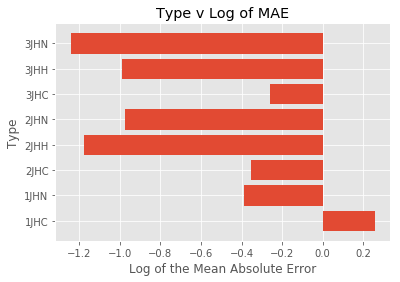

In [119]:
type_score = {}
plt.style.use('ggplot')
for i in range(len(test_scores)):
    type_score[J_type_list[i]] = test_scores[i]
  
plt.barh(list(type_score.keys()), list(type_score.values()))
plt.xlabel('Log of the Mean Absolute Error')
plt.ylabel('Type')
plt.title('Type v Log of MAE');

This plot gives an idea of validation score obtained by subtracting the test value from predicted value as log of MAE and the smaller, the better. The smallest is -1.27 by 3JHN type.

In [110]:
!pip install seaborn

In [5]:
import matplotlib as plt
import seaborn as sns
%matplotlib inline
# plt.figure(figsize=(10,10))


from matplotlib import *
import sys
from pylab import *



# 17. Plotting target for all the coupling types togther

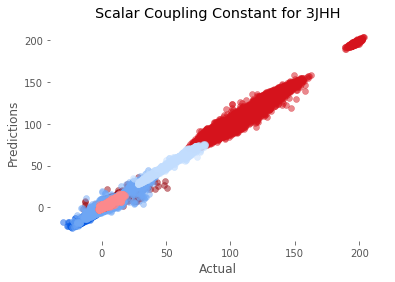

In [109]:
plots = [test_3JHH, test_3JHC, test_2JHH, test_1JHC, test_2JHC, test_3JHN, test_1JHN, test_2JHN]
colors = ['#0040cc', '#96040e',  '#075be6', '#D5131C', '#6fa7f5',  '#F23B41',   '#c2ddfe', '#FC8A8D']
names = ['1JHC', '1JHN', '2JHC', '2JHN', '2JHH', '3JHC', '3JHN', '3JHH']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'], marker='o',color=cc, alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title(f'Scalar Coupling Constant for {name}')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

Inference: we can see that the predictions lie well within the range of actual valuesfor all the coupling types. This can be considered as accurate as predicted values are linearly related to the actual values.

# 18. Scalar Coupling Constant VS Predictions after shuffling

In [110]:
test_final_shuffle = test_final.sample(frac=1, random_state=47)

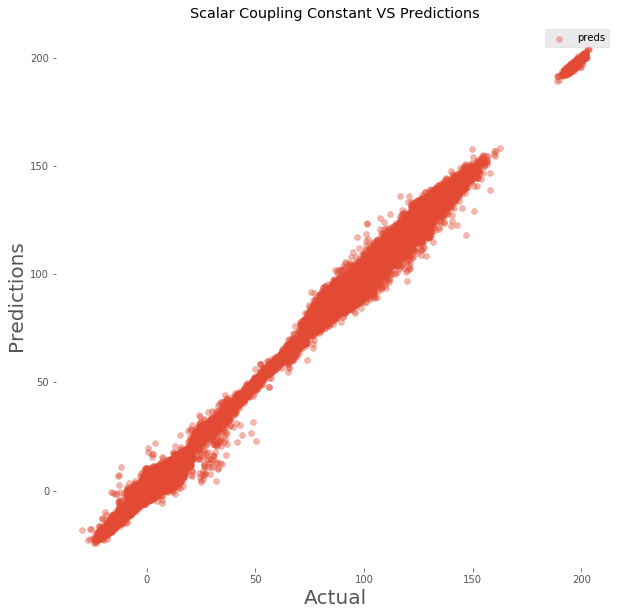

In [111]:
# palette = ['#86ACDE', '#5929E0', '#A4E6FC', '#E6090C', '#2765EB', '#1B04DB', '#911DE1', '#4353DF']
palette = ['#86ACDE', '#5929E0', '#A4E6FC']
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
plt.scatter(test_final_shuffle['scalar_coupling_constant'], test_final_shuffle['preds'],
                marker='o',
                alpha=.4)

plt.box(False)
plt.grid(False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.title('Scalar Coupling Constant VS Predictions')
plt.legend();

Inference:After shuffling we find that the correlation between actual and preducted is quite linear.

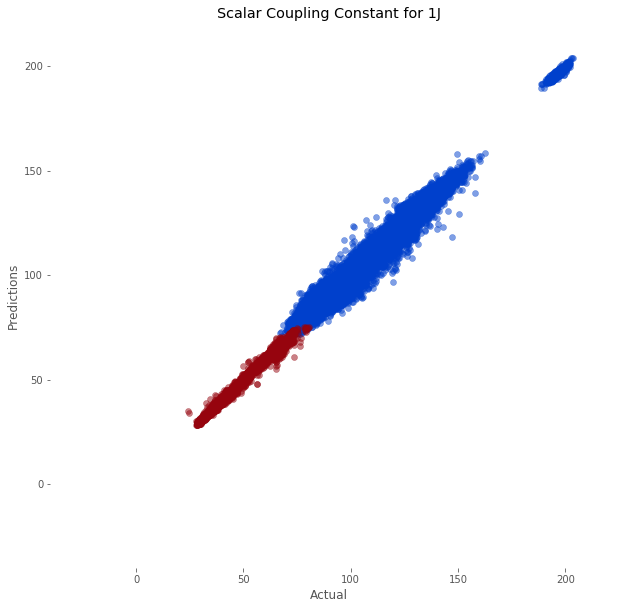

In [112]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [test_1JHC, test_1JHN]
colors = ['#0040cc', '#96040e']
names = ['1JHC', '1JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title('Scalar Coupling Constant for 1J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break

This shows a linear correlation between the actual and predicted for 1j type coupling.

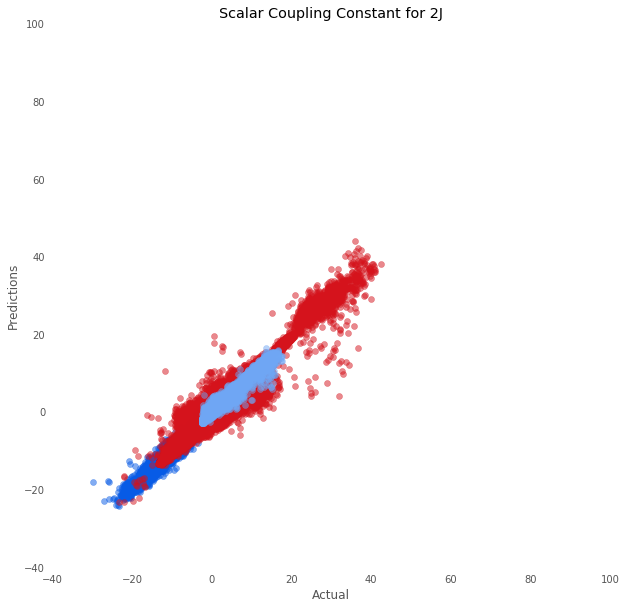

In [113]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [test_2JHH, test_2JHC, test_2JHN]
colors = ['#075be6', '#D5131C', '#6fa7f5']
names = ['2JHH', '2JHC', '2JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title('Scalar Coupling Constant for 2J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 100)
      plt.ylim(-40, 100)
      plt.tick_params(
              axis='x',          # changes apply to the x-axis
              which='both',      # both major and minor ticks are affected
              bottom=False,      # ticks along the bottom edge are off
              top=False,         # ticks along the top edge are off
              labelbottom=True) # labels along the bottom edge are off
      plt.tick_params(
              axis='y',          # changes apply to the x-axis
              which='both',      # both major and minor ticks are affected
              bottom=False,      # ticks along the bottom edge are off
              top=False,
              left=False,        # ticks along the top edge are off
              labelbottom=False) # labels along the bottom edge are off
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

This shows a linear correlation between the actual and predicted values for 2J type coupling.

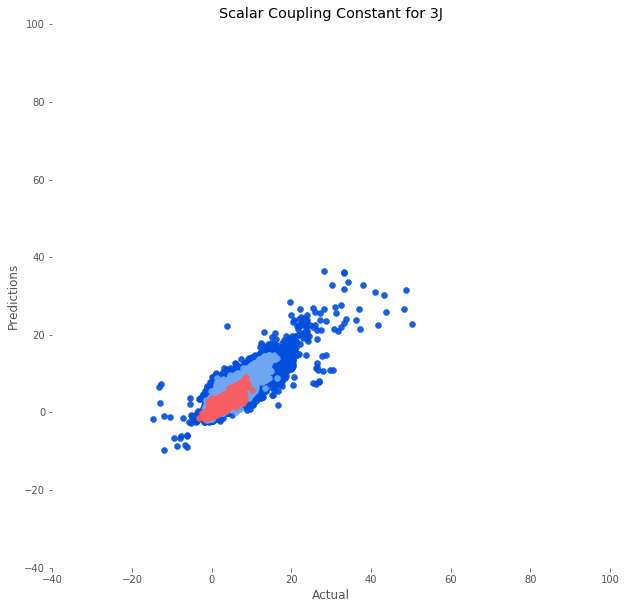

In [114]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [test_3JHC, test_3JHH, test_3JHN]
colors = ['#004fde', '#6fa7f5', '#F95D61']
names = ['3JHC', '3JHH', '3JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.9)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title(f'Scalar Coupling Constant for 3J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 100)
      plt.ylim(-40, 100)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

This shows a linear correlation between the actual and predicted values for 3J type coupling.

# 19. Permutation Importance (importance of features) for each type is listed here. 
Here I am trying to study the effect of features on various types of coupling, using the weights. I want to check the hypothesis that the coupling types have varied effects of various features and want to confirm most useful features common for all. This might be helpful when it is required to design a better model.

In [115]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_1JHC = PermutationImportance(clf_1JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_1JHC.fit(X_test_1JHC, y_test_1JHC)
feature_names_1JHC = X_test_1JHC.columns.tolist()
eli5.show_weights(permuter_1JHC, top=20, feature_names=feature_names_1JHC)

Weight,Feature
50.5899 ± 0.3155,n_bonds_y
40.3635 ± 0.0267,distance
27.8764 ± 0.2816,bond_lengths_mean_y
17.0987 ± 0.0185,mulliken_charge_1
14.8784 ± 0.0212,mulliken_charge_0
10.2739 ± 0.0834,atom_1_couples_count
8.9033 ± 0.0102,molecule_atom_index_1_dist_min
3.7380 ± 0.0256,molecule_atom_index_0_dist_min
3.1859 ± 0.0305,bond_lengths_mean_x
2.6223 ± 0.0325,molecule_atom_index_0_dist_max_div


In [116]:
df_1JHC_imp = eli5.explain_weights_df(permuter_1JHC, top=None, feature_names=feature_names_1JHC)
df_1JHC_imp = df_1JHC_imp.drop('std', axis=1)
df_1JHC_imp.head()

,feature,weight
0,n_bonds_y,50.589879
1,distance,40.363473
2,bond_lengths_mean_y,27.876447
3,mulliken_charge_1,17.098652
4,mulliken_charge_0,14.878380


In [182]:
permuter_1JHN = PermutationImportance(clf_1JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_1JHN.fit(X_test_1JHN, y_test_1JHN)
feature_names_1JHN = X_test_1JHN.columns.tolist()
eli5.show_weights(permuter_1JHN, top=None, feature_names=feature_names_1JHN)

Weight,Feature
70.9051 ± 1.7414,molecule_atom_index_1_dist_min
26.1694 ± 0.1043,mulliken_charge_0
17.2222 ± 0.4329,bond_lengths_mean_y
5.1958 ± 0.0173,mulliken_charge_1
1.2929 ± 0.0160,n_bonds_y
0.6504 ± 0.0240,molecule_atom_index_0_dist_mean_div
0.4697 ± 0.0279,distance
0.4507 ± 0.0115,atom_1_couples_count
0.3510 ± 0.0075,molecule_atom_index_0_dist_max
0.1879 ± 0.0033,distance_0


In [183]:
df_1JHN_imp = eli5.explain_weights_df(permuter_1JHN, top=None, feature_names=feature_names_1JHN)
df_1JHN_imp = df_1JHN_imp.drop('std', axis=1)
df_1JHN_imp.head()

,feature,weight
0,molecule_atom_index_1_dist_min,70.905075
1,mulliken_charge_0,26.169391
2,bond_lengths_mean_y,17.222150
3,mulliken_charge_1,5.195847
4,n_bonds_y,1.292890


In [185]:
permuter_2JHH = PermutationImportance(clf_2JHH, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHH.fit(X_test_2JHH, y_test_2JHH)
feature_names_2JHH = X_test_2JHH.columns.tolist()
eli5.show_weights(permuter_2JHH, top=None, feature_names=feature_names_2JHH)

Weight,Feature
4.9362 ± 0.0100,molecule_atom_index_1_dist_min
4.8031 ± 0.0011,distance
3.9077 ± 0.0204,bond_lengths_mean_y
0.9561 ± 0.0079,mulliken_charge_0
0.8988 ± 0.0041,mulliken_charge_1
0.5471 ± 0.0072,molecule_atom_index_0_dist_min
0.3136 ± 0.0011,bond_lengths_mean_x
0.2706 ± 0.0049,atom_0_couples_count
0.2296 ± 0.0009,molecule_atom_index_0_dist_mean
0.1261 ± 0.0014,molecule_atom_index_1_dist_mean


In [186]:
df_2JHH_imp = eli5.explain_weights_df(permuter_2JHH, top=None, feature_names=feature_names_2JHH)
df_2JHH_imp = df_2JHH_imp.drop('std', axis=1)
df_2JHH_imp.head()

,feature,weight
0,molecule_atom_index_1_dist_min,4.936211
1,distance,4.803075
2,bond_lengths_mean_y,3.907727
3,mulliken_charge_0,0.956112
4,mulliken_charge_1,0.898834


In [187]:
permuter_2JHC = PermutationImportance(clf_2JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHC.fit(X_test_2JHC, y_test_2JHC)
feature_names_2JHC = X_test_2JHC.columns.tolist()
eli5.show_weights(permuter_2JHC, top=None, feature_names=feature_names_2JHC)

Weight,Feature
4.8869 ± 0.0207,molecule_atom_index_0_dist_min
4.5158 ± 0.0223,bond_lengths_mean_x
3.1476 ± 0.0610,atom_0_couples_count
2.9844 ± 0.0134,mulliken_charge_0
2.2552 ± 0.0172,distance
1.6284 ± 0.0097,n_bonds_y
1.5771 ± 0.0007,bond_lengths_mean_y
1.3653 ± 0.0000,molecule_atom_index_0_dist_max
1.0827 ± 0.0251,mulliken_charge_1
0.9901 ± 0.0025,molecule_atom_index_1_dist_min


In [188]:
df_2JHC_imp = eli5.explain_weights_df(permuter_2JHC, top=None, feature_names=feature_names_2JHC)
df_2JHC_imp = df_2JHC_imp.drop('std', axis=1)
df_2JHC_imp.head()

,feature,weight
0,molecule_atom_index_0_dist_min,4.886944
1,bond_lengths_mean_x,4.515842
2,atom_0_couples_count,3.147589
3,mulliken_charge_0,2.984394
4,distance,2.255193


In [116]:
import eli5
from eli5.sklearn import PermutationImportance
permuter_2JHN = PermutationImportance(clf_2JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHN.fit(X_test_2JHN, y_test_2JHN)
feature_names_2JHN = X_test_2JHN.columns.tolist()
eli5.show_weights(permuter_2JHN, top=None, feature_names=feature_names_2JHN)

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Weight,Feature
3.3270 ± 0.0065,n_bonds_y
2.2787 ± 0.0532,molecule_atom_index_0_dist_min
2.1103 ± 0.0029,bond_lengths_mean_x
1.5021 ± 0.0095,atom_0_couples_count
1.0320 ± 0.0048,bond_lengths_mean_y
1.0276 ± 0.0126,molecule_atom_index_0_dist_max
0.7851 ± 0.0006,distance
0.6563 ± 0.0131,molecule_atom_index_1_dist_min_diff
0.5108 ± 0.0117,mulliken_charge_0
0.5023 ± 0.0024,molecule_atom_index_0_dist_mean_div


In [117]:
df_2JHN_imp = eli5.explain_weights_df(permuter_2JHN, top=None, feature_names=feature_names_2JHN)
df_2JHN_imp = df_2JHN_imp.drop('std', axis=1)
df_2JHN_imp.head()

,feature,weight
0,n_bonds_y,3.327019
1,molecule_atom_index_0_dist_min,2.278661
2,bond_lengths_mean_x,2.110305
3,atom_0_couples_count,1.502098
4,bond_lengths_mean_y,1.031995


In [120]:
permuter_3JHH = PermutationImportance(clf_3JHH, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHH.fit(X_test_3JHH, y_test_3JHH)
feature_names_3JHH = X_test_3JHH.columns.tolist()
eli5.show_weights(permuter_3JHH, top=None, feature_names=feature_names_3JHH)

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Weight,Feature
6.3154 ± 0.0660,molecule_atom_1_dist_min_div
5.0046 ± 0.0290,distance
3.5128 ± 0.0026,bond_lengths_mean_y
1.5176 ± 0.0041,bond_lengths_mean_x
0.5741 ± 0.0009,molecule_atom_index_1_dist_max
0.4073 ± 0.0011,atom_0_couples_count
0.3957 ± 0.0023,mulliken_charge_1
0.3879 ± 0.0009,molecule_atom_index_0_dist_min
0.3730 ± 0.0002,molecule_atom_1_dist_min_diff
0.2781 ± 0.0059,molecule_atom_index_0_dist_mean_diff


In [121]:
df_3JHH_imp = eli5.explain_weights_df(permuter_3JHH, top=None, feature_names=feature_names_3JHH)
df_3JHH_imp = df_3JHH_imp.drop('std', axis=1)
df_3JHH_imp.head()

,feature,weight
0,molecule_atom_1_dist_min_div,6.315368
1,distance,5.004580
2,bond_lengths_mean_y,3.512802
3,bond_lengths_mean_x,1.517606
4,molecule_atom_index_1_dist_max,0.574139


In [124]:
permuter_3JHC = PermutationImportance(clf_3JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHC.fit(X_test_3JHC, y_test_3JHC)
feature_names_3JHC = X_test_3JHC.columns.tolist()
eli5.show_weights(permuter_3JHC, top=None, feature_names=feature_names_3JHC)

C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\praty\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_

KeyboardInterrupt: 

In [0]:
df_3JHC_imp = eli5.explain_weights_df(permuter_3JHC, top=None, feature_names=feature_names_3JHC)
df_3JHC_imp = df_3JHC_imp.drop('std', axis=1)
df_3JHC_imp.head()

,feature,weight
0,distance,2.636834
1,bond_lengths_mean_y,1.336917
2,bond_lengths_mean_x,0.909996
3,n_bonds_y,0.840672
4,molecule_atom_index_0_dist_min,0.733543


In [0]:
permuter_3JHN = PermutationImportance(clf_3JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHN.fit(X_val_3JHN_encoded, y_val_3JHN)
feature_names_3JHN = X_val_3JHN_encoded.columns.tolist()
eli5.show_weights(permuter_3JHN, top=None, feature_names=feature_names_3JHN)

Weight,Feature
0.4843 ± 0.0119,molecule_atom_index_0_dist_mean_diff
0.3066 ± 0.0053,bond_lengths_mean_x
0.2883 ± 0.0050,mulliken_charge_1
0.2728 ± 0.0005,molecule_atom_index_1_dist_min_diff
0.2612 ± 0.0031,distance
0.2036 ± 0.0025,bond_lengths_mean_y
0.1441 ± 0.0019,mulliken_charge_0
0.1048 ± 0.0009,n_bonds_y
0.0708 ± 0.0028,molecule_atom_index_1_dist_min
0.0699 ± 0.0018,molecule_atom_index_0_dist_min


# Inference: The dataset was extremely limited in features, so the model relies heavily on engineering a lot of new features
1. Using data that included known molecular properties of molecules, I created machine learning models to predict the scalar coupling constant of a pair of atoms. 8 different LightGBM Regressor models were used to predict the target for each type of coupling: 1JHC, 1JHN, 2JHH, 2JHC, 2JHN, 3JHH, 3JHC, 3JHH, resulting in a final score of -0.64.
2. More than 50 features were engineered to help train the models accurately and improve the validation scores. Some features were very helpful for the models, some not so much, and the ones that did not impact the score at all were discarded. It was also found that over cluttering the data with bunch of features could also hurt the score, so a few of those features were removed as well.
3. The validation scores for each J coupling type were obtained and it was found that it varies with the type of coupling.The model predicting the 3JHN coupling constants performed the best with a validation score of -1.242, and the model predicting the 1JHC coupling constants performed the worst with a validation score of 0.258.
4. The significant differences in validation scores between models is due to features that are unaccounted for in our dataset that likely have a large effect on that specific type of coupling. To improve those scores further, some features we can try engineering are ones that take dipole interactions, magnetic shielding, and potential energy into account.
5. All of the models had different permutation importances depending on the type of coupling. Some of the most common features with high importance for each model were the distance, mulliken_charges, and both of the bond_lengths (x and y).
6. Here model is broken down by its respective validation score and permutation importances. 
7. Making use of the premutations and knowing about the best featuers impacting the scalar coupling constant using some more features MAE could br reduced further and model could be made more generalized.